**Exercício 1: Análise de Internações no Sistema de Saúde Brasileiro**

<p>Você foi contratado(a) para fazer uma análise apurada do número de internações no
sistema de saúde brasileiro. Esta análise é de extrema importância para tomada de
decisões que deverão contribuir para melhorias no sistema e planejamento estratégico.
Os dados em anexo (case_internacao_SUS.xls) são referentes às internações que
ocorreram no país durante o período de dezembro de 2017 a julho de 2019, separados
por região e unidade de federação (Fonte: Ministério da Saúde - Sistema de Informações
Hospitalares do SUS (SIH/SUS)).
Acesse http://tabnet.datasus.gov.br/cgi/sih/sxdescr.htm para obter uma descrição
detalhada dos dados.</p>

Desafios:<br>
**1. Tratamento dos dados**

    1.1. Muitas vezes, cerca de 70% do tempo de um projeto é despendido na coleta e tratamento dos dados. Sabendo disso, leia o arquivo e o transforme de modo a ter mais facilidade em analisar os dados. Lembre-se que essa etapa poderá te dar bons insumos. Portanto, capriche!
 
**2. Análise**

     2.1. Dados tratados, bora explorá-los? Faça uma boa EDA e não esqueça de anotar todos os insights que você obter. Gráficos e informações sem uma boa interpretação não valem, ok?
     
**3. Modelagem**

     3.1. Agora que já tem certa intimidade com os dados, cite pelo menos 2 métodos possíveis para estimar os dados para os meses faltantes. Tente não se complicaraqui. Utilize os métodos mais simples e mais funcionais possíveis. Neste tópico,é importante que argumente o porquê dos métodos recomendados.
            
    3.2. Escolha um desses métodos e estime a) o número de Internações e b) o Valor Total das internações nos períodos faltantes.
    
    3.3. Crie um modelo que preveja a) as Internações, b) o número de Óbitos e c) o Valor Médio de AIH pelos próximos 6 meses. Explique a escolha do modelo e quais parâmetros utilizou para serem input no modelo.
    
**4. Planejamento estratégico**

    4.1. Com base nos dados e nas suas análises, que tipo de estratégia você sugeriria para diminuir o número de internações em hospitais do SUS? E para o Estado de São Paulo? Quais especificidades deveriam ser levadas em conta? 
    
 <p>Ao final, escreva um relatório contendo todos os gráficos gerados bem como as argumentações, análises e insights de sua EDA (item 2.1). Neste relatório também
deverá conter a argumentação do porquê dos métodos citados no item 3.1 são cabíveis
aos dados disponibilizados. Além disso, devem ser incorporadas ao relatório as análises
ou argumentos que te levaram a optar pelo método escolhido para a modelagem
requerida nos itens 3.2 e 3.3. Não esqueça de anexar ao relatório toda argumentação e
apontamentos para o questionamento feito no item 4.1.</p>


# 0.0 Imports

In [3]:
import warnings

import pandas as pd
import inflection
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from IPython.core.display  import HTML
from IPython.display       import Image
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima

## 0.1 Funções auxiliares

In [4]:
#função para aumentar largura do jupyter notebook e definir layout dos gráficos
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
jupyter_settings()


pd.set_option('display.float_format', lambda x: '%.3f' % x)


Populating the interactive namespace from numpy and matplotlib


/home/lrayssa/Documents/petz_analista_jr/petz/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.2 Obtenção dos dados

In [5]:
data = pd.read_excel('../data/case_internacao_SUS.xls', sheet_name=None)
df_raw = pd.DataFrame()
for key in data.keys():
    df = data[key]
    df['data'] = key
    df_raw = pd.concat([df_raw, df], axis=0)
    

df_raw

,Região/Unidade da Federação,Internações,AIH_aprovadas,Valor_total,Valor_serviços_hospitalares,Val_serv_hosp_-_compl_federal,Val_serv_hosp_-_compl_gestor,Valor_serviços_profissionais,Val_serv_prof_-_compl_federal,Val_serv_prof_-_compl_gestor,Valor_médio_AIH,Valor_médio_intern,Dias_permanência,Média_permanência,Óbitos,Taxa_mortalidade,data
0,Região Norte,75363.000,75363.000,65821821.590,50592273.100,282125.280,-,14820122.530,-,-,873.400,873.400,358202.000,4.800,2149.000,2.850,jul19
1,.. Rondônia,9603.000,9603.000,9404751.410,7666945.900,-,-,1737805.510,-,-,979.360,979.360,53043.000,5.500,315.000,3.280,jul19
2,.. Amazonas,16248.000,16248.000,15624312.730,12166634.070,1221.310,-,3455637.920,-,-,961.610,961.610,85512.000,5.300,536.000,3.300,jul19
3,.. Roraima,4324.000,4324.000,3137537.400,2356231.680,-,-,781305.720,-,-,725.610,725.610,25560.000,5.900,171.000,3.950,jul19
4,.. Pará,34774.000,34774.000,28178633.440,21241354.070,248197.250,-,6581738.700,-,-,810.340,810.340,138135.000,4.000,832.000,2.390,jul19
5,.. Amapá,3407.000,3407.000,2380727.690,1776869.350,-,-,603858.340,-,-,698.780,698.780,18703.000,5.500,85.000,2.490,jul19
6,.. Tocantins,7007.000,7007.000,7095858.920,5384238.030,32706.720,-,1659776.340,-,-,1012.680,1012.680,37249.000,5.300,210.000,3.000,jul19
7,Região Nordeste,267944.000,271043.000,313074118.770,245438887.750,1563326.930,29897.600,65245510.570,29897.600,27798.960,1155.070,1168.430,1395106.000,5.200,10575.000,3.950,jul19
8,.. Maranhão,33351.000,33766.000,28658094.550,22448136.820,50267.110,-,6134105.820,-,-,848.730,859.290,166594.000,5.000,879.000,2.640,jul19
9,.. Piauí,16590.000,16727.000,16275611.730,12938857.110,77814.460,-,3217744.000,-,-,973.010,981.050,81932.000,4.900,480.000,2.890,jul19


# 1.0 Descrição dos dados

## 1.1. Renomeação das colunas

Região/unidade de federação
Internações (AIH aprovadas no período sem considerar prorrogação)
AIH aprovadas (AIH são as autorizações para internação hospitalar - contempla novas e prorrogações)
Valor total -> referente as AIH aprovadas no período, valor aprovado de produção e não necessariamente repassado
Valor serviços hospitalares
Valores serviços hospitalares complemento federal
Valores serviços hospitalares complemento gestor (estadual ou municiapl

In [6]:
df1 = df_raw.copy()

In [7]:
cols_old = df1.columns
lower = lambda x: x.lower()

cols_new = list( map( lower, cols_old ) )

df1.columns = cols_new

In [8]:
df1.columns = ['uf', 'internacoes', 'aih_aprovadas',
       'valor_total', 'valor_servicos_hospitalares',
       'val_serv_hosp_compl_federal', 'val_serv_hosp_compl_gestor',
       'valor_serviços_profissionais', 'val_serv_prof_compl_federal',
       'val_serv_prof_compl_gestor', 'valor_medio_aih', 'valor_medio_intern',
       'dias_permanência', 'media_permanencia', 'obitos', 'taxa_mortalidade',
       'data']

In [9]:
df1.head()

,uf,internacoes,aih_aprovadas,valor_total,valor_servicos_hospitalares,val_serv_hosp_compl_federal,val_serv_hosp_compl_gestor,valor_serviços_profissionais,val_serv_prof_compl_federal,val_serv_prof_compl_gestor,valor_medio_aih,valor_medio_intern,dias_permanência,media_permanencia,obitos,taxa_mortalidade,data
0,Região Norte,75363.000,75363.000,65821821.590,50592273.100,282125.280,-,14820122.530,-,-,873.400,873.400,358202.000,4.800,2149.000,2.850,jul19
1,.. Rondônia,9603.000,9603.000,9404751.410,7666945.900,-,-,1737805.510,-,-,979.360,979.360,53043.000,5.500,315.000,3.280,jul19
2,.. Amazonas,16248.000,16248.000,15624312.730,12166634.070,1221.310,-,3455637.920,-,-,961.610,961.610,85512.000,5.300,536.000,3.300,jul19
3,.. Roraima,4324.000,4324.000,3137537.400,2356231.680,-,-,781305.720,-,-,725.610,725.610,25560.000,5.900,171.000,3.950,jul19
4,.. Pará,34774.000,34774.000,28178633.440,21241354.070,248197.250,-,6581738.700,-,-,810.340,810.340,138135.000,4.000,832.000,2.390,jul19


## 1.2 Separação de dados de estados e região

In [10]:
#checando quais são os estados e regiões únicos nos dados
df1['uf'].unique()

array(['Região Norte', '.. Rondônia', '.. Amazonas', '.. Roraima',
       '.. Pará', '.. Amapá', '.. Tocantins', 'Região Nordeste',
       '.. Maranhão', '.. Piauí', '.. Ceará', '.. Rio Grande do Norte',
       '.. Paraíba', '.. Pernambuco', '.. Alagoas', '.. Sergipe',
       '.. Bahia', 'Região Sudeste', '.. Minas Gerais',
       '.. Espírito Santo', '.. Rio de Janeiro', '.. São Paulo',
       'Região Sul', '.. Paraná', '.. Santa Catarina',
       '.. Rio Grande do Sul', 'Região Centro-Oeste',
       '.. Mato Grosso do Sul', '.. Mato Grosso', '.. Goiás',
       '.. Distrito Federal', 'Total', nan, ' ', '.. Acre'], dtype=object)

In [11]:
#checando as linhas com dados de região vazios
df1[df1['uf'].isnull()]

,uf,internacoes,aih_aprovadas,valor_total,valor_servicos_hospitalares,val_serv_hosp_compl_federal,val_serv_hosp_compl_gestor,valor_serviços_profissionais,val_serv_prof_compl_federal,val_serv_prof_compl_gestor,valor_medio_aih,valor_medio_intern,dias_permanência,media_permanencia,obitos,taxa_mortalidade,data
32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,jul19
33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,jul19
34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,jul19
35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,jul19
36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,jul19


In [12]:
# como todas as linhas de uf vazios são vazias, vamos filtrar apenas os dados de uf não nulos
df1 = df1[df1['uf'].notnull()]

In [13]:
df1.head()

,uf,internacoes,aih_aprovadas,valor_total,valor_servicos_hospitalares,val_serv_hosp_compl_federal,val_serv_hosp_compl_gestor,valor_serviços_profissionais,val_serv_prof_compl_federal,val_serv_prof_compl_gestor,valor_medio_aih,valor_medio_intern,dias_permanência,media_permanencia,obitos,taxa_mortalidade,data
0,Região Norte,75363.000,75363.000,65821821.590,50592273.100,282125.280,-,14820122.530,-,-,873.400,873.400,358202.000,4.800,2149.000,2.850,jul19
1,.. Rondônia,9603.000,9603.000,9404751.410,7666945.900,-,-,1737805.510,-,-,979.360,979.360,53043.000,5.500,315.000,3.280,jul19
2,.. Amazonas,16248.000,16248.000,15624312.730,12166634.070,1221.310,-,3455637.920,-,-,961.610,961.610,85512.000,5.300,536.000,3.300,jul19
3,.. Roraima,4324.000,4324.000,3137537.400,2356231.680,-,-,781305.720,-,-,725.610,725.610,25560.000,5.900,171.000,3.950,jul19
4,.. Pará,34774.000,34774.000,28178633.440,21241354.070,248197.250,-,6581738.700,-,-,810.340,810.340,138135.000,4.000,832.000,2.390,jul19


In [14]:
# estados possuem pontos (.) antes dos seus nomes, portanto vamos filtrar apenas os que são estados
df1 = df1[df1['uf'].str.contains('.', regex=False)]

In [15]:
df1['uf'].unique()

array(['.. Rondônia', '.. Amazonas', '.. Roraima', '.. Pará', '.. Amapá',
       '.. Tocantins', '.. Maranhão', '.. Piauí', '.. Ceará',
       '.. Rio Grande do Norte', '.. Paraíba', '.. Pernambuco',
       '.. Alagoas', '.. Sergipe', '.. Bahia', '.. Minas Gerais',
       '.. Espírito Santo', '.. Rio de Janeiro', '.. São Paulo',
       '.. Paraná', '.. Santa Catarina', '.. Rio Grande do Sul',
       '.. Mato Grosso do Sul', '.. Mato Grosso', '.. Goiás',
       '.. Distrito Federal', '.. Acre'], dtype=object)

## 1.3 Limpeza da coluna uf

In [16]:
df1['uf'] = df1['uf'].apply(lambda x: x.replace('.',''))
df1['uf'] = df1['uf'].apply(lambda x: x.lstrip())
df1['uf'] = df1['uf'].apply(lambda x: x.rstrip())
    
    
    
    
#df1['uf'] = df1['uf'].apply(lambda x: inflection.underscore( x ))

In [17]:
estados = {
    'AC': 'Acre',
    'AL': 'Alagoas',
    'AP': 'Amapá',
    'AM': 'Amazonas',
    'BA': 'Bahia',
    'CE': 'Ceará',
    'DF': 'Distrito Federal',
    'ES': 'Espírito Santo',
    'GO': 'Goiás',
    'MA': 'Maranhão',
    'MT': 'Mato Grosso',
    'MS': 'Mato Grosso do Sul',
    'MG': 'Minas Gerais',
    'PA': 'Pará',
    'PB': 'Paraíba',
    'PR': 'Paraná',
    'PE': 'Pernambuco',
    'PI': 'Piauí',
    'RJ': 'Rio de Janeiro',
    'RN': 'Rio Grande do Norte',
    'RS': 'Rio Grande do Sul',
    'RO': 'Rondônia',
    'RR': 'Roraima',
    'SC': 'Santa Catarina',
    'SP': 'São Paulo',
    'SE': 'Sergipe',
    'TO': 'Tocantins'
}

estados_1 = {v: k for k, v in estados.items()}

df1['uf'] = df1['uf'].map(estados_1)

In [18]:
df1.head()

,uf,internacoes,aih_aprovadas,valor_total,valor_servicos_hospitalares,val_serv_hosp_compl_federal,val_serv_hosp_compl_gestor,valor_serviços_profissionais,val_serv_prof_compl_federal,val_serv_prof_compl_gestor,valor_medio_aih,valor_medio_intern,dias_permanência,media_permanencia,obitos,taxa_mortalidade,data
1,RO,9603.000,9603.000,9404751.410,7666945.900,-,-,1737805.510,-,-,979.360,979.360,53043.000,5.500,315.000,3.280,jul19
2,AM,16248.000,16248.000,15624312.730,12166634.070,1221.310,-,3455637.920,-,-,961.610,961.610,85512.000,5.300,536.000,3.300,jul19
3,RR,4324.000,4324.000,3137537.400,2356231.680,-,-,781305.720,-,-,725.610,725.610,25560.000,5.900,171.000,3.950,jul19
4,PA,34774.000,34774.000,28178633.440,21241354.070,248197.250,-,6581738.700,-,-,810.340,810.340,138135.000,4.000,832.000,2.390,jul19
5,AP,3407.000,3407.000,2380727.690,1776869.350,-,-,603858.340,-,-,698.780,698.780,18703.000,5.500,85.000,2.490,jul19


## 1.4 Substituição do - por NaN

In [19]:
for i in df1.columns:
    df1[df1[i] == '-'] = df1[df1[i] == '-'].apply(lambda x: x.replace('-', np.NaN))

## 1.5 Dimensão dos dados

In [20]:
print('numero_de_linhas: {}'.format(df1.shape[0]))
print('numero_de_colunas: {}'.format(df1.shape[1]))

numero_de_linhas: 377
numero_de_colunas: 17


## 1.6 Tipos dos dados

In [21]:
df1.dtypes

uf                               object
internacoes                     float64
aih_aprovadas                   float64
valor_total                     float64
valor_servicos_hospitalares     float64
val_serv_hosp_compl_federal      object
val_serv_hosp_compl_gestor       object
valor_serviços_profissionais    float64
val_serv_prof_compl_federal      object
val_serv_prof_compl_gestor       object
valor_medio_aih                 float64
valor_medio_intern              float64
dias_permanência                float64
media_permanencia               float64
obitos                          float64
taxa_mortalidade                float64
data                             object
dtype: object

## 1.7 Check de dados faltantes

In [22]:
df1.isna().sum()

uf                                0
internacoes                       0
aih_aprovadas                     0
valor_total                       0
valor_servicos_hospitalares       0
val_serv_hosp_compl_federal     126
val_serv_hosp_compl_gestor      305
valor_serviços_profissionais      0
val_serv_prof_compl_federal     305
val_serv_prof_compl_gestor      315
valor_medio_aih                   0
valor_medio_intern                0
dias_permanência                  0
media_permanencia                 0
obitos                            0
taxa_mortalidade                  0
data                              0
dtype: int64

In [23]:
df1 = df1[df1['internacoes'].notnull()]

In [24]:
df1.isna().sum()

uf                                0
internacoes                       0
aih_aprovadas                     0
valor_total                       0
valor_servicos_hospitalares       0
val_serv_hosp_compl_federal     126
val_serv_hosp_compl_gestor      305
valor_serviços_profissionais      0
val_serv_prof_compl_federal     305
val_serv_prof_compl_gestor      315
valor_medio_aih                   0
valor_medio_intern                0
dias_permanência                  0
media_permanencia                 0
obitos                            0
taxa_mortalidade                  0
data                              0
dtype: int64

## 1.8 Alteração dos tipos dos dados

In [25]:
#separar mês de ano
df1['mes'] = df1['data'].apply(lambda x: x[0:3])
df1['ano'] = df1['data'].apply(lambda x: x[-2:])

#substituir meses extensos por números
meses = {'jan':'1', 'fev':'2', 'mar':'3', 'abr':'4', 'mai':'5', 'jun':'6', 'jul':'7', 'ago':'8', 'set':'9', 'out':'10', 'nov':'11', 'dez':'12'}
for k,v in meses.items():
    df1['mes'] = df1['mes'].apply(lambda x: x.replace(k,v))

#transformar ano em 04 dígitos
df1['ano'] = df1['ano'].apply(lambda x: '20'+x)

#unir as datas
df1['data'] = df1['ano']+'-'+df1['mes']



In [26]:
#converter para datetime

df1['data'] = pd.to_datetime(df1['data'], format='%Y-%m')

df1.head()

,uf,internacoes,aih_aprovadas,valor_total,valor_servicos_hospitalares,val_serv_hosp_compl_federal,val_serv_hosp_compl_gestor,valor_serviços_profissionais,val_serv_prof_compl_federal,val_serv_prof_compl_gestor,valor_medio_aih,valor_medio_intern,dias_permanência,media_permanencia,obitos,taxa_mortalidade,data,mes,ano
1,RO,9603.000,9603.000,9404751.410,7666945.900,NaN,NaN,1737805.510,NaN,NaN,979.360,979.360,53043.000,5.500,315.000,3.280,2019-07-01,7,2019
2,AM,16248.000,16248.000,15624312.730,12166634.070,1221.310,NaN,3455637.920,NaN,NaN,961.610,961.610,85512.000,5.300,536.000,3.300,2019-07-01,7,2019
3,RR,4324.000,4324.000,3137537.400,2356231.680,NaN,NaN,781305.720,NaN,NaN,725.610,725.610,25560.000,5.900,171.000,3.950,2019-07-01,7,2019
4,PA,34774.000,34774.000,28178633.440,21241354.070,248197.250,NaN,6581738.700,NaN,NaN,810.340,810.340,138135.000,4.000,832.000,2.390,2019-07-01,7,2019
5,AP,3407.000,3407.000,2380727.690,1776869.350,NaN,NaN,603858.340,NaN,NaN,698.780,698.780,18703.000,5.500,85.000,2.490,2019-07-01,7,2019


## 1.9 Preenchimento de dados faltantes 

In [27]:
# se não houve complemento do governo federal ou do gestor, então os dados faltantes podem ser preenchidos com 0
df1.fillna(0, inplace=True)

In [28]:
df1.head()

,uf,internacoes,aih_aprovadas,valor_total,valor_servicos_hospitalares,val_serv_hosp_compl_federal,val_serv_hosp_compl_gestor,valor_serviços_profissionais,val_serv_prof_compl_federal,val_serv_prof_compl_gestor,valor_medio_aih,valor_medio_intern,dias_permanência,media_permanencia,obitos,taxa_mortalidade,data,mes,ano
1,RO,9603.000,9603.000,9404751.410,7666945.900,0.000,0.000,1737805.510,0.000,0.000,979.360,979.360,53043.000,5.500,315.000,3.280,2019-07-01,7,2019
2,AM,16248.000,16248.000,15624312.730,12166634.070,1221.310,0.000,3455637.920,0.000,0.000,961.610,961.610,85512.000,5.300,536.000,3.300,2019-07-01,7,2019
3,RR,4324.000,4324.000,3137537.400,2356231.680,0.000,0.000,781305.720,0.000,0.000,725.610,725.610,25560.000,5.900,171.000,3.950,2019-07-01,7,2019
4,PA,34774.000,34774.000,28178633.440,21241354.070,248197.250,0.000,6581738.700,0.000,0.000,810.340,810.340,138135.000,4.000,832.000,2.390,2019-07-01,7,2019
5,AP,3407.000,3407.000,2380727.690,1776869.350,0.000,0.000,603858.340,0.000,0.000,698.780,698.780,18703.000,5.500,85.000,2.490,2019-07-01,7,2019


## 1.10 Inserção dos períodos faltantes

In [29]:
sorted(df1['data'].unique())

[numpy.datetime64('2017-12-01T00:00:00.000000000'),
 numpy.datetime64('2018-03-01T00:00:00.000000000'),
 numpy.datetime64('2018-04-01T00:00:00.000000000'),
 numpy.datetime64('2018-05-01T00:00:00.000000000'),
 numpy.datetime64('2018-07-01T00:00:00.000000000'),
 numpy.datetime64('2018-08-01T00:00:00.000000000'),
 numpy.datetime64('2018-09-01T00:00:00.000000000'),
 numpy.datetime64('2018-11-01T00:00:00.000000000'),
 numpy.datetime64('2018-12-01T00:00:00.000000000'),
 numpy.datetime64('2019-01-01T00:00:00.000000000'),
 numpy.datetime64('2019-02-01T00:00:00.000000000'),
 numpy.datetime64('2019-04-01T00:00:00.000000000'),
 numpy.datetime64('2019-06-01T00:00:00.000000000'),
 numpy.datetime64('2019-07-01T00:00:00.000000000')]

Meses faltantes: <br>
2018: jan, fev, jun, out <br>
2019: mar, mai,

In [30]:
# criar dataset com os timestamps e demais dados vazios

aux = pd.DataFrame(columns=df1.columns)
missing_data = [datetime.date(2018, 1, 1), datetime.date(2018, 2, 1), datetime.date(2018, 6, 1), datetime.date(2018, 10, 1), datetime.date(2019, 3, 1), datetime.date(2019, 5, 1) ]
for i in range(0, len(df1['uf'].unique())):
    for  j in range(0, len(missing_data)):
        aux1 = pd.DataFrame([[df1['uf'].unique()[i],np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN,
                       missing_data[j], np.NaN, np.NaN]], columns=df1.columns)

        aux = pd.concat([aux, aux1])



In [31]:
aux.head()

,uf,internacoes,aih_aprovadas,valor_total,valor_servicos_hospitalares,val_serv_hosp_compl_federal,val_serv_hosp_compl_gestor,valor_serviços_profissionais,val_serv_prof_compl_federal,val_serv_prof_compl_gestor,valor_medio_aih,valor_medio_intern,dias_permanência,media_permanencia,obitos,taxa_mortalidade,data,mes,ano
0,RO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01,NaN,NaN
0,RO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-02-01,NaN,NaN
0,RO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-06-01,NaN,NaN
0,RO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-10-01,NaN,NaN
0,RO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-03-01,NaN,NaN


In [32]:
aux['mes'] = pd.DatetimeIndex(aux['data']).month
aux['ano'] = pd.DatetimeIndex(aux['data']).year

In [33]:
aux['mes'] = aux['mes'].apply(lambda x: str(x))
aux['ano'] = aux['ano'].apply(lambda x: str(x))

In [34]:
aux.dtypes

uf                              object
internacoes                     object
aih_aprovadas                   object
valor_total                     object
valor_servicos_hospitalares     object
val_serv_hosp_compl_federal     object
val_serv_hosp_compl_gestor      object
valor_serviços_profissionais    object
val_serv_prof_compl_federal     object
val_serv_prof_compl_gestor      object
valor_medio_aih                 object
valor_medio_intern              object
dias_permanência                object
media_permanencia               object
obitos                          object
taxa_mortalidade                object
data                            object
mes                             object
ano                             object
dtype: object

In [35]:
df1.shape

(377, 19)

In [36]:
df1 = pd.concat([df1, aux])

In [37]:
df1 = df1.sort_values(by='data')

/home/lrayssa/Documents/petz_analista_jr/petz/lib/python3.8/site-packages/pandas/core/sorting.py:403: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  indexer = non_nan_idx[non_nans.argsort(kind=kind)]


In [38]:
df1 = df1.reset_index(drop=True)

In [39]:
df1.head()

,uf,internacoes,aih_aprovadas,valor_total,valor_servicos_hospitalares,val_serv_hosp_compl_federal,val_serv_hosp_compl_gestor,valor_serviços_profissionais,val_serv_prof_compl_federal,val_serv_prof_compl_gestor,valor_medio_aih,valor_medio_intern,dias_permanência,media_permanencia,obitos,taxa_mortalidade,data,mes,ano
0,RN,12602.000,12820.000,18311840.010,14275181.730,0.000,0.000,4036658.280,0.000,0.000,1428.380,1453.090,74577.000,5.900,515.000,4.090,2017-12-01 00:00:00,12,2017
1,RO,9783.000,9783.000,7507845.130,5931386.180,0.000,0.000,1576458.950,0.000,0.000,767.440,767.440,42043.000,4.300,235.000,2.400,2017-12-01 00:00:00,12,2017
2,AC,3463.000,3487.000,2610454.550,1966308.650,0.000,0.000,644145.900,0.000,0.000,748.620,753.810,16660.000,4.800,106.000,3.060,2017-12-01 00:00:00,12,2017
3,AM,14337.000,14337.000,13169660.320,10020114.860,0.000,0.000,3149545.460,0.000,0.000,918.580,918.580,72629.000,5.100,403.000,2.810,2017-12-01 00:00:00,12,2017
4,RR,3513.000,3513.000,2635287.450,1986327.470,0.000,0.000,648959.980,0.000,0.000,750.150,750.150,18231.000,5.200,87.000,2.480,2017-12-01 00:00:00,12,2017


In [40]:
df1['data'] = pd.to_datetime(df1['data'], format='%Y-%m')

/home/lrayssa/Documents/petz_analista_jr/petz/lib/python3.8/site-packages/pandas/core/indexes/base.py:2023: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return self._engine.is_unique
/home/lrayssa/Documents/petz_analista_jr/petz/lib/python3.8/site-packages/pandas/core/indexes/base.py:3512: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  indexer = self._engine.get_indexer(target._get_engine_target())


In [41]:
# interpolação, substituição pela média ou mediana, média móvel, autoregressão

In [42]:
#df1['media_movel_internacoes'] = df1.loc[:,'internacoes'].rolling(window=1).mean()

#df['pandas_SMA_3'] = df.iloc[:,1].rolling(window=3).mean()

In [43]:
#df1.head()

## 1.12 Estatística descritiva

In [44]:
df1_aux = df1[df1['internacoes'].notnull()]

In [45]:
df1_aux.describe().T

,count,mean,std,min,25%,50%,75%,max
internacoes,377.000,36730.122,41822.123,2493.000,13815.000,18548.000,45745.000,215787.000
aih_aprovadas,377.000,37290.427,42871.755,2493.000,14031.000,18692.000,46197.000,221589.000
valor_total,377.000,47289906.232,60559440.104,1716855.560,14813113.790,21652391.730,64648373.690,304314139.970
valor_servicos_hospitalares,377.000,37576679.543,48491902.210,1220961.050,11760235.810,16990975.310,50944376.940,243788851.050
val_serv_hosp_compl_federal,377.000,209835.192,423808.873,0.000,0.000,36395.320,218924.310,3225164.410
val_serv_hosp_compl_gestor,377.000,13037.610,66756.502,0.000,0.000,0.000,0.000,1196505.380
valor_serviços_profissionais,377.000,9363297.204,11495940.067,451661.700,3205745.280,4628712.750,13283495.530,57735646.860
val_serv_prof_compl_federal,377.000,13037.610,66756.502,0.000,0.000,0.000,0.000,1196505.380
val_serv_prof_compl_gestor,377.000,9716.989,44947.191,0.000,0.000,0.000,0.000,618387.200
valor_medio_aih,377.000,1126.888,255.745,622.210,918.580,1139.840,1339.320,1691.840


In [46]:
df1_aux.head()

,uf,internacoes,aih_aprovadas,valor_total,valor_servicos_hospitalares,val_serv_hosp_compl_federal,val_serv_hosp_compl_gestor,valor_serviços_profissionais,val_serv_prof_compl_federal,val_serv_prof_compl_gestor,valor_medio_aih,valor_medio_intern,dias_permanência,media_permanencia,obitos,taxa_mortalidade,data,mes,ano
0,RN,12602.000,12820.000,18311840.010,14275181.730,0.000,0.000,4036658.280,0.000,0.000,1428.380,1453.090,74577.000,5.900,515.000,4.090,2017-12-01,12,2017
1,RO,9783.000,9783.000,7507845.130,5931386.180,0.000,0.000,1576458.950,0.000,0.000,767.440,767.440,42043.000,4.300,235.000,2.400,2017-12-01,12,2017
2,AC,3463.000,3487.000,2610454.550,1966308.650,0.000,0.000,644145.900,0.000,0.000,748.620,753.810,16660.000,4.800,106.000,3.060,2017-12-01,12,2017
3,AM,14337.000,14337.000,13169660.320,10020114.860,0.000,0.000,3149545.460,0.000,0.000,918.580,918.580,72629.000,5.100,403.000,2.810,2017-12-01,12,2017
4,RR,3513.000,3513.000,2635287.450,1986327.470,0.000,0.000,648959.980,0.000,0.000,750.150,750.150,18231.000,5.200,87.000,2.480,2017-12-01,12,2017


In [47]:
aux = df1_aux[['data', 'internacoes']].groupby('data').sum()
aux.describe().T


,count,mean,std,min,25%,50%,75%,max
internacoes,14.000,989089.714,30786.978,932863.000,971441.250,999819.000,1013778.250,1020220.000


In [48]:
aux = df1_aux[['data', 'internacoes']].groupby('data').mean()

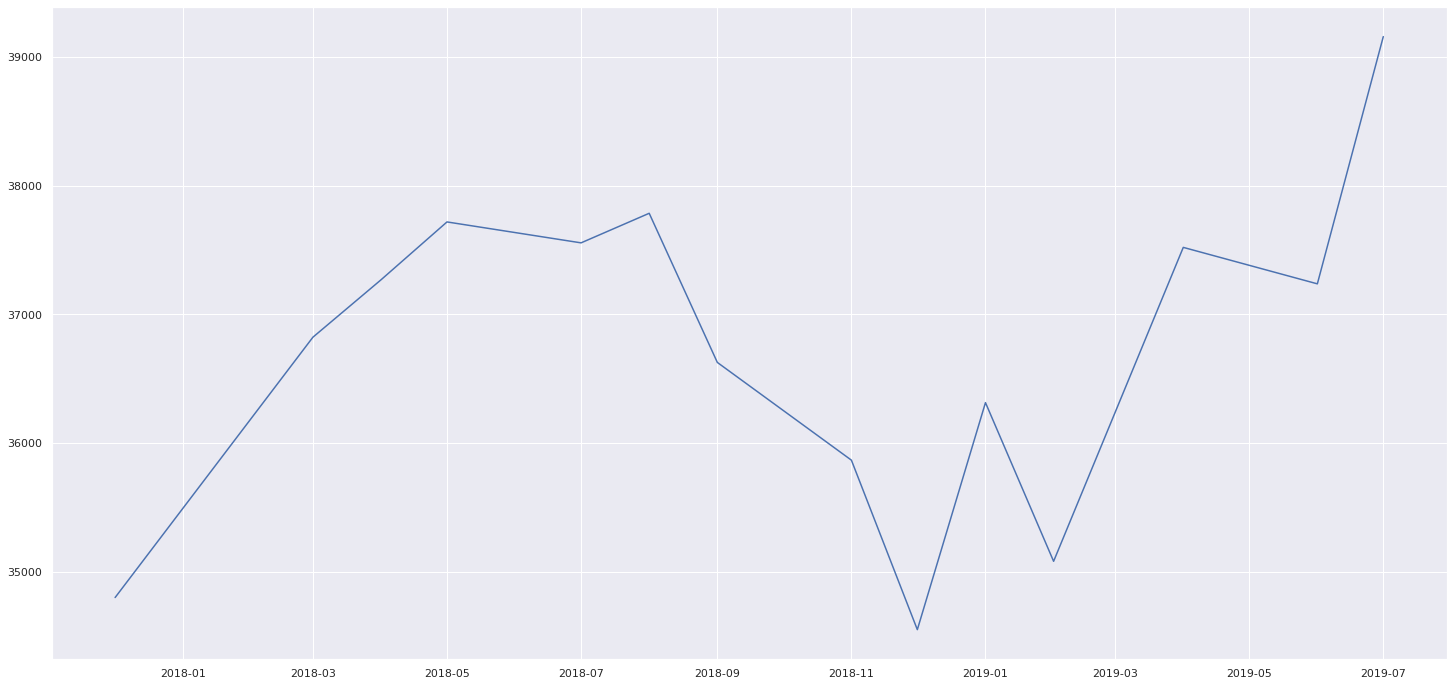

In [49]:
plt.plot(aux)

# 2.0 Feature engineering

In [50]:
df2 = df1.copy()

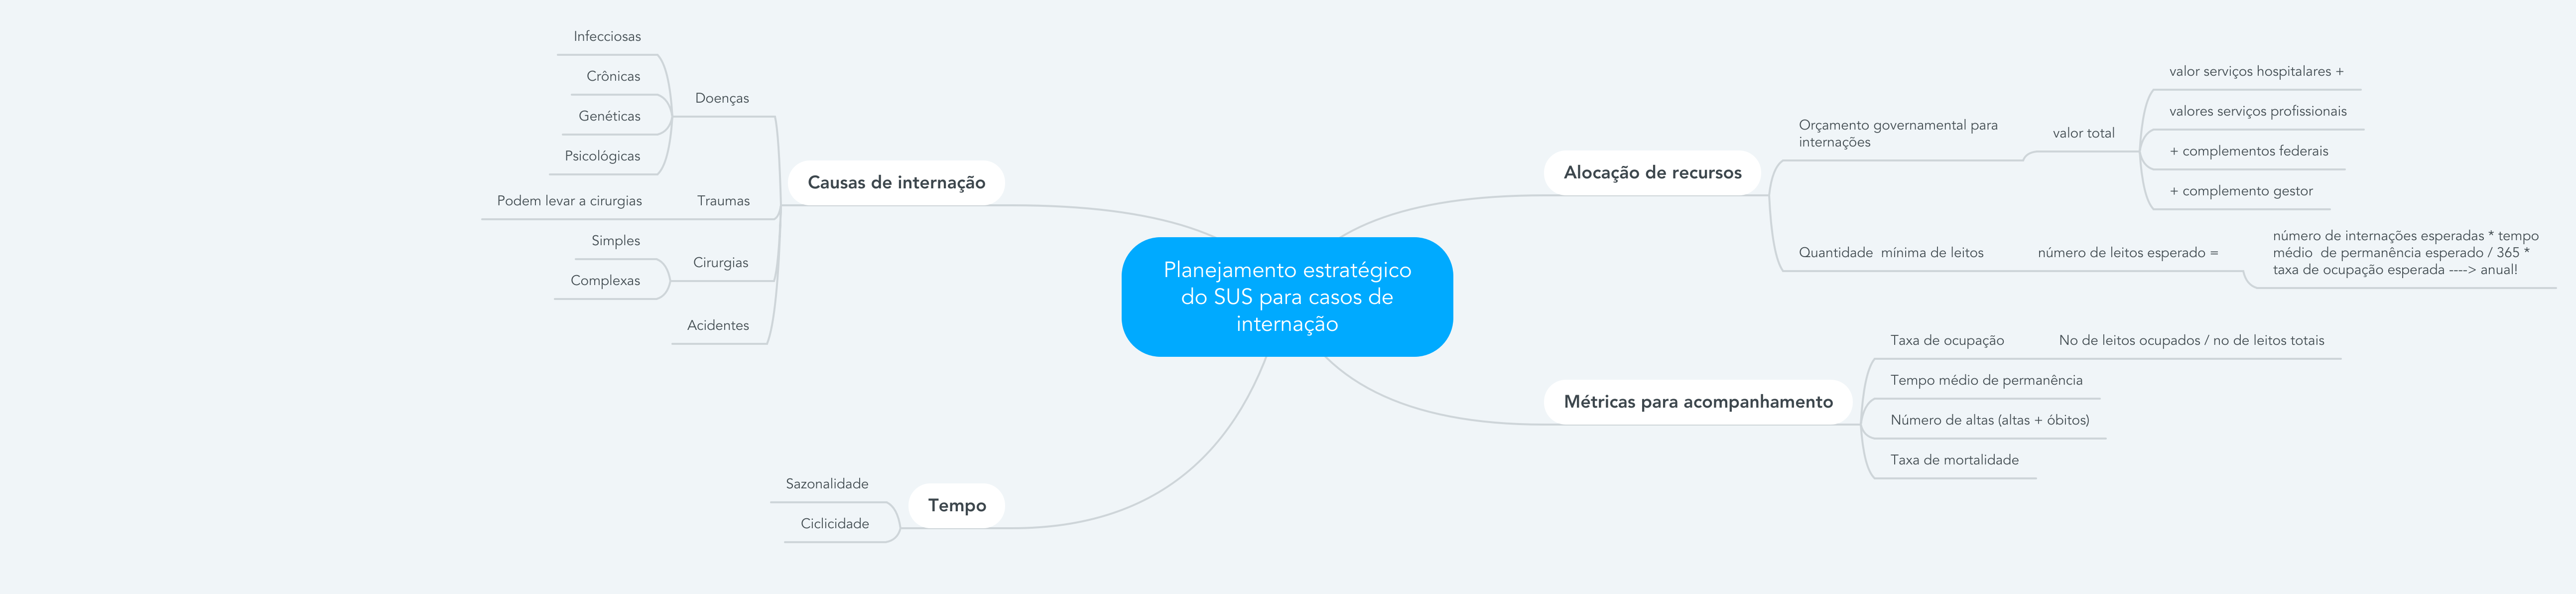

In [51]:
Image( '../references/mindmap.png' )

**Alocação de recursos** <br>
**H1.** O valor total pago por internações deve ser maior na região Sudeste, sendo o estado de São Paulo o estao que deve destinar o maior valor de orçamento para internações. <br>
**H2.** A maior proporção dos complementos federais em relação ao valor total pago devem é a da região nordeste. <br>
**H3.** A maior pproporção dos complementos gestor em relação ao valor total pago deve estar na região sul. <br>
**H4.** O valor médio dos serviços profissionais deve ser maior na região Sudeste e Sul, respectivamente. <br>
**H5.** O maior número de leitos esperado deve estar na região Sudeste. <br> 
**H6.** A região sudeste é a que deve possuir mais leitos (esperados) por habitante <br> 
**H7.** Os estados da região Norte devem ser os que possuem menos leitos (esperados) por habitantes. <br>
**H8.** O valor médio das internações pagas deve ser maior no estado de São Paulo e Distrito Federal, respectivamente <br>
<br>


**Métricas** <br>
**H9.** O tempo médio de permanência deve ser maior em estados do Nordeste <br>
**H10.** A taxa de mortalidade deve ser maior em estados do Norte e Nordesete, respectivamente. <br>
**H11.** A região Sudeste deve concentrar o maior número de prorrogaões de internação que os outros estados.<br>
<br>

**Tempo**<br>
**H12.** O número médio de internações deve ser maior em meses de inverno para todos os estados do Brasil.<br>
**H13.** O tempo médio de internação deve ser maior nos meses de inverno.<br>
**H14.** O comportamento das internações no tempo deve ser igual para ttodos os estados do Brasil<br>

In [52]:
#região
norte = ['AM', 'PA', 'AP', 'AC', 'RR', 'RO', 'TO']
nordeste = ['MA', 'PI', 'CE', 'RN', 'PB', 'PE', 'SE', 'BA', 'AL']
centro_oeste = ['MT', 'MS', 'GO', 'DF']
sudeste = ['MG', 'ES', 'RJ', 'SP']
sul = ['PR', 'SC', 'RS']

df2['regiao'] = df2['uf'].apply(lambda x: 'norte' if x in norte else 'nordeste' if x in nordeste else 'centro-oeste' if x in centro_oeste else 'sudeste' if x in sudeste else 'sul' if x in sul else np.NaN)


#numero de leitos esperado
df2['no_leitos_ocupado'] = (df2['aih_aprovadas'] * df2['media_permanencia']) / 30



#população de cada estado

populacao = pd.read_csv('../data/tabela6579.csv')

populacao.columns = ['nivel', 'uf', '2017', '2018', '2019']

populacao['uf'] = populacao['uf'].map(estados_1)


df2 = df2.merge(populacao, how='inner', on='uf')

df2.loc[df2['ano'] == '2017', 'populacao'] =df2.loc[df2['ano'] == '2017', '2017']
df2.loc[df2['ano'] == '2018', 'populacao'] =df2.loc[df2['ano'] == '2018', '2018']
df2.loc[df2['ano'] == '2019', 'populacao'] =df2.loc[df2['ano'] == '2019', '2019']
df2 = df2.drop(columns=['nivel', '2017', '2018', '2019'])



#prorrogações

df2['prorrogacoes'] = df2['aih_aprovadas'] - df2['internacoes']

#complemento federal
df2['complemento_federal'] = df2['val_serv_hosp_compl_federal'] + df2['val_serv_prof_compl_federal']

#complemento gestor
df2['complemento_gestor'] = df2['val_serv_hosp_compl_gestor'] + df2['val_serv_prof_compl_gestor']

In [53]:
df2.head()

,uf,internacoes,aih_aprovadas,valor_total,valor_servicos_hospitalares,val_serv_hosp_compl_federal,val_serv_hosp_compl_gestor,valor_serviços_profissionais,val_serv_prof_compl_federal,val_serv_prof_compl_gestor,valor_medio_aih,valor_medio_intern,dias_permanência,media_permanencia,obitos,taxa_mortalidade,data,mes,ano,regiao,no_leitos_ocupado,populacao,prorrogacoes,complemento_federal,complemento_gestor
0,RN,12602.000,12820.000,18311840.010,14275181.730,0.000,0.000,4036658.280,0.000,0.000,1428.380,1453.090,74577.000,5.900,515.000,4.090,2017-12-01,12,2017,nordeste,2521.267,3507003.000,218.000,0.000,0.000
1,RN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01,1,2018,nordeste,NaN,3479010.000,NaN,NaN,NaN
2,RN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-02-01,2,2018,nordeste,NaN,3479010.000,NaN,NaN,NaN
3,RN,14246.000,14465.000,19842834.930,15481270.690,0.000,0.000,4361564.240,0.000,0.000,1371.780,1392.870,80678.000,5.700,527.000,3.700,2018-03-01,3,2018,nordeste,2748.350,3479010.000,219.000,0.000,0.000
4,RN,15363.000,15576.000,20774806.620,16189665.490,0.000,0.000,4585141.130,0.000,0.000,1333.770,1352.260,91424.000,6.000,594.000,3.870,2018-04-01,4,2018,nordeste,3115.200,3479010.000,213.000,0.000,0.000


# 3.0 Filtragem do dataset

In [54]:
df3 = df2[['data', 'mes', 'ano', 'uf', 'regiao','internacoes', 'prorrogacoes', 'aih_aprovadas', 'valor_total', 'complemento_federal', 'complemento_gestor', 
           'valor_serviços_profissionais','valor_medio_intern', 'valor_medio_aih', 'no_leitos_ocupado', 'obitos','taxa_mortalidade', 'populacao', 'media_permanencia']]

In [55]:
#df3 = df3.dropna(axis=0)

In [56]:
df3.head()

,data,mes,ano,uf,regiao,internacoes,prorrogacoes,aih_aprovadas,valor_total,complemento_federal,complemento_gestor,valor_serviços_profissionais,valor_medio_intern,valor_medio_aih,no_leitos_ocupado,obitos,taxa_mortalidade,populacao,media_permanencia
0,2017-12-01,12,2017,RN,nordeste,12602.000,218.000,12820.000,18311840.010,0.000,0.000,4036658.280,1453.090,1428.380,2521.267,515.000,4.090,3507003.000,5.900
1,2018-01-01,1,2018,RN,nordeste,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3479010.000,NaN
2,2018-02-01,2,2018,RN,nordeste,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3479010.000,NaN
3,2018-03-01,3,2018,RN,nordeste,14246.000,219.000,14465.000,19842834.930,0.000,0.000,4361564.240,1392.870,1371.780,2748.350,527.000,3.700,3479010.000,5.700
4,2018-04-01,4,2018,RN,nordeste,15363.000,213.000,15576.000,20774806.620,0.000,0.000,4585141.130,1352.260,1333.770,3115.200,594.000,3.870,3479010.000,6.000


# 4.0 Análise exploraoria de dados (EDA)

In [57]:
df4 = df3.copy()

## 4.1 Análise univariada

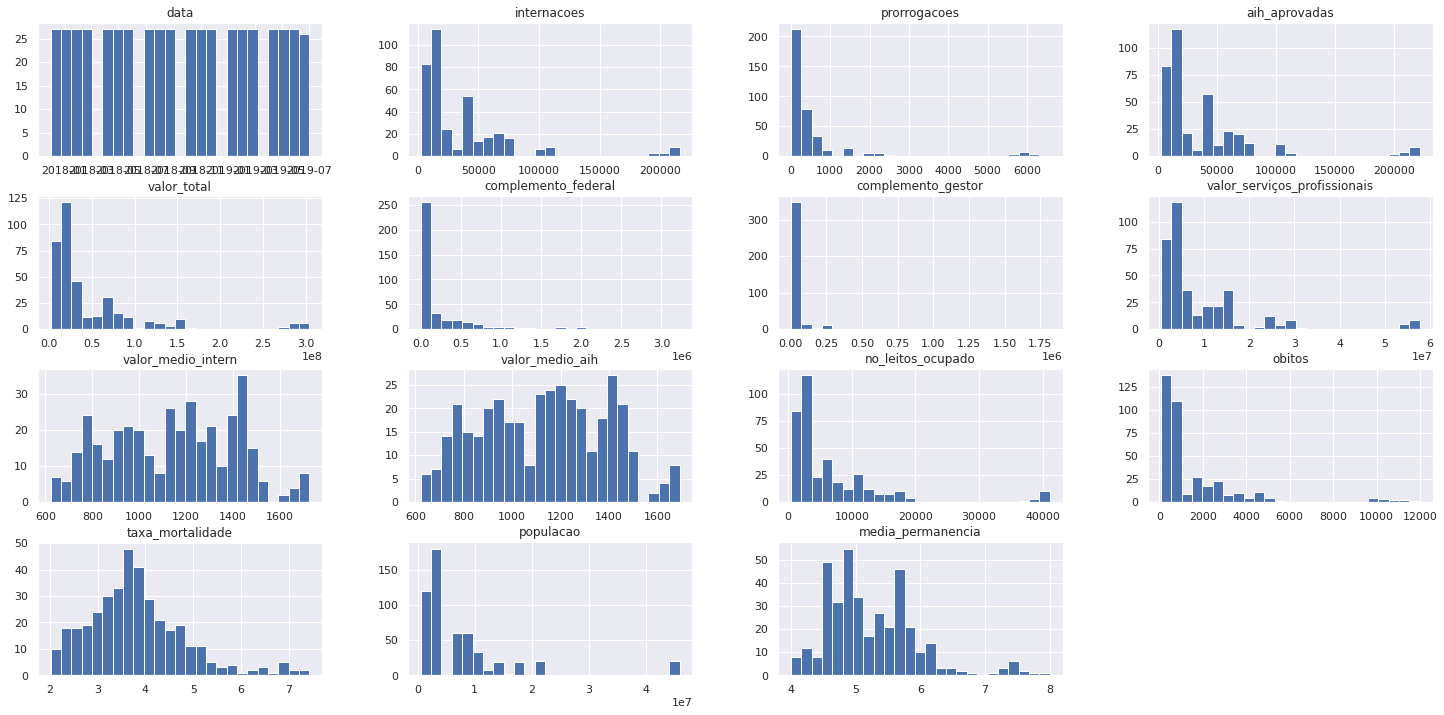

In [58]:
# análise univariada - distribuição
df4.hist(bins = 25);

## 4.2. Análise bivariada

In [59]:
# análise bivariada (teste das hipóteses)

### H1. O valor total pago por internações deve ser maior na região Sudeste, sendo o estado de São Paulo o estado que deve destinar o maior valor de orçamento para internações.
**VERDADEIRA.** O valor total pago por internações é maior na região Sudeste, sendo que São Paulo deve receber pelo menos 53.27% dos valor orçamentário para pagamentos de internações da região e 22,724% do valor orçamentário do para este fim do país

In [60]:
#gasto total mensal por cada região (plot de linhas)
#gasto total mensal por estado

Text(0, 0.5, 'Valor pago em internações x 100 milhões de R$')

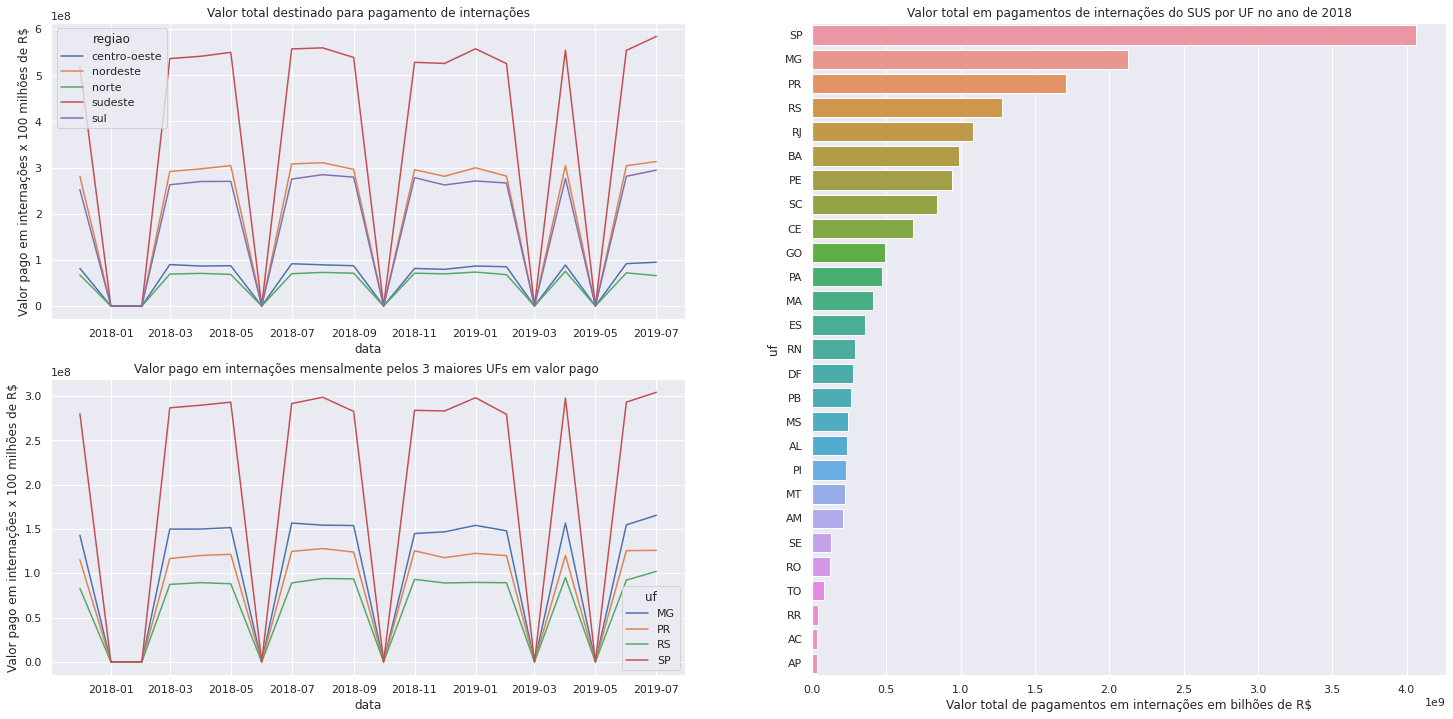

In [61]:
plt.subplot(2, 2, 1)
aux1 = df4[['data', 'regiao', 'valor_total']].groupby(['data','regiao']).sum().reset_index()
sns.lineplot(x='data', y='valor_total', hue='regiao', data=aux1)
plt.title('Valor total destinado para pagamento de internações')
plt.ylabel('Valor pago em internações x 100 milhões de R$')


plt.subplot(2, 2, (2,4))
aux2 = df4[['ano', 'uf', 'valor_total']].groupby('uf').sum().sort_values(by='valor_total', ascending=False).reset_index()
sns.barplot(x='valor_total', y='uf', data=aux2)
plt.title('Valor total em pagamentos de internações do SUS por UF no ano de 2018')
plt.xlabel('Valor total de pagamentos em internações em bilhões de R$');


plt.subplot(2, 2, 3)
aux3 = df4[['data', 'uf', 'valor_total']].groupby(['data','uf']).sum().reset_index()
aux3 = aux3[aux3['uf'].isin(['SP', 'MG', 'PR', 'RS'])]
sns.lineplot(x='data', y='valor_total', hue='uf', data=aux3)
plt.title('Valor pago em internações mensalmente pelos 3 maiores UFs em valor pago ')
plt.ylabel('Valor pago em internações x 100 milhões de R$')

In [62]:
aux4 = df4[df4['ano']=='2018'][['uf', 'regiao', 'valor_total']].groupby(['regiao', 'uf']).sum().reset_index()

proporcao_valor_internacoes_SP_Brasil = aux4[aux4['uf']== 'SP']['valor_total'].sum()/aux4['valor_total'].sum() *100
print('{}% do valor total repassado para pagamento das internações em 2018 foi para o estado de São Paulo'.format(round(proporcao_valor_internacoes_SP_Brasil,2)))

proporcao_valor_internacoes_SP_sudeste = aux4[aux4['uf']== 'SP']['valor_total'].sum()/aux4[aux4['regiao']== 'sudeste']['valor_total'].sum() *100
print('São Paulo representa {}% do valor total pago em internações na região Sudeste em 2018'.format(round(proporcao_valor_internacoes_SP_sudeste,2)))

22.74% do valor total repassado para pagamento das internações em 2018 foi para o estado de São Paulo
São Paulo representa 53.27% do valor total pago em internações na região Sudeste em 2018


In [63]:
#valor anual pago por habitante

### H2. A maior proporção dos complementos federais em relação ao valor total pago devem é a da região nordeste.
**FALSA.** A maior proporção dos complementos federais em relação ao valor total pago é a da região Sudeste. A regiao nordeste, apesar de ocupar o 2 lugar em valor absoluto de complemento, está em quarta posição na comparação complementos federais x valor total pago

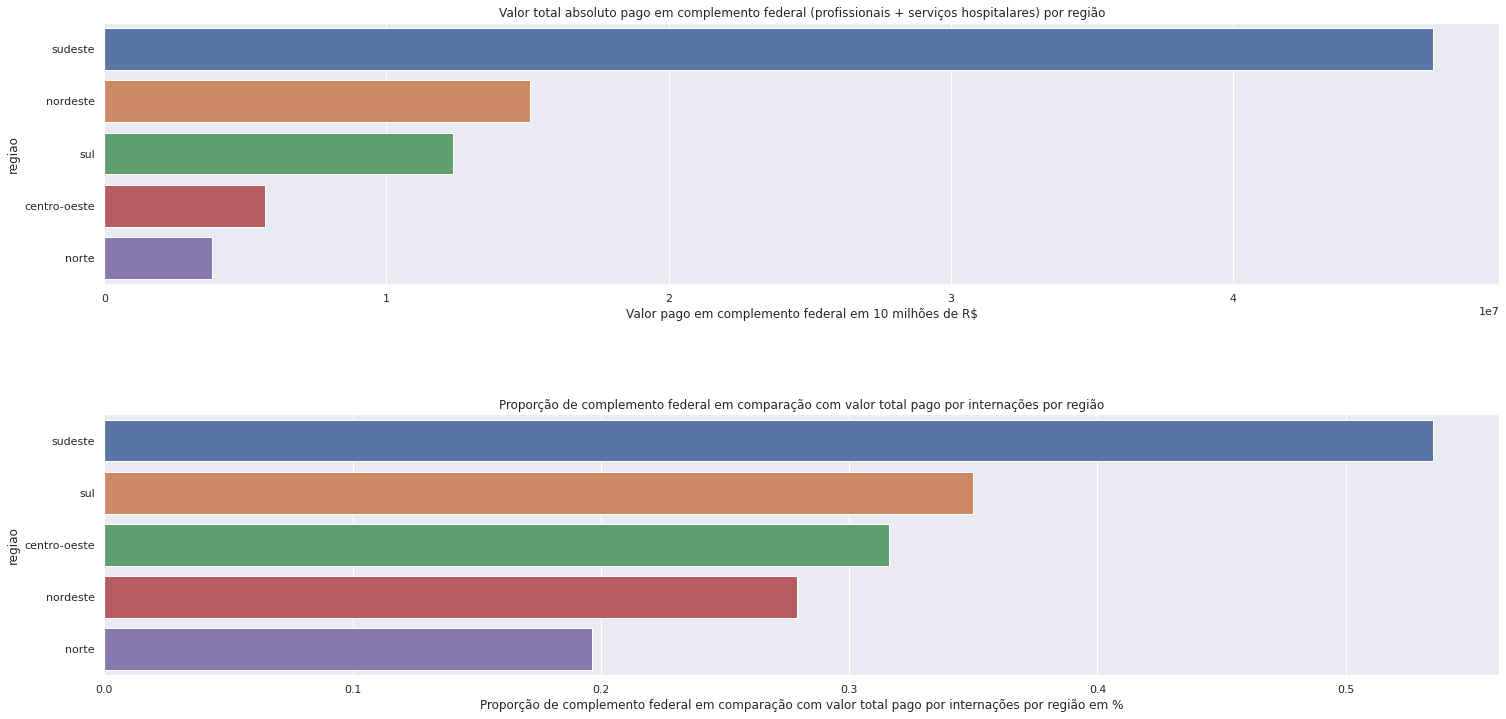

In [64]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    plt.subplot(2,1,1)
    aux1 = df4[['regiao', 'complemento_federal']].groupby('regiao').sum().sort_values(by='complemento_federal', ascending=False).reset_index()
    sns.barplot(x='complemento_federal', y='regiao', data=aux1)
    plt.title('Valor total absoluto pago em complemento federal (profissionais + serviços hospitalares) por região')
    plt.xlabel('Valor pago em complemento federal em 10 milhões de R$')
    plt.subplots_adjust(hspace = 0.5)

    plt.subplot(2,1,2)
    aux2 = df4[['regiao', 'complemento_federal', 'valor_total']]
    aux2['proporcao_complemento_federal'] = (aux2['complemento_federal'] / (aux2['complemento_federal'] + aux2['valor_total']) )*100
    aux3 = aux2[['regiao', 'proporcao_complemento_federal']].groupby('regiao').mean().sort_values(by='proporcao_complemento_federal', ascending=False).reset_index()
    sns.barplot(x='proporcao_complemento_federal', y='regiao', data=aux3)
    plt.title('Proporção de complemento federal em comparação com valor total pago por internações por região')
    plt.xlabel('Proporção de complemento federal em comparação com valor total pago por internações por região em %');

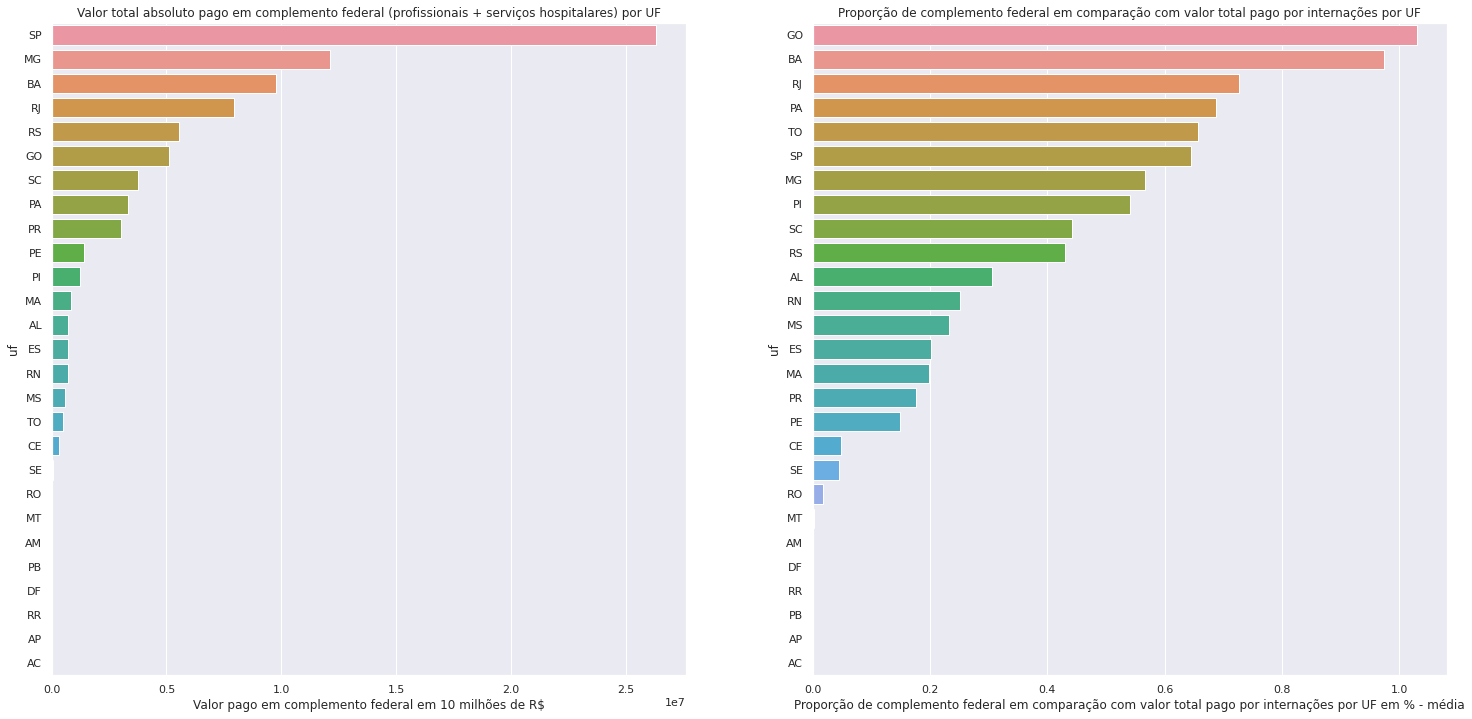

In [65]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    plt.subplot(1,2,1)
    aux1 = df4[['uf', 'complemento_federal']].groupby('uf').sum().sort_values(by='complemento_federal', ascending=False).reset_index()
    sns.barplot(x='complemento_federal', y='uf', data=aux1)
    plt.title('Valor total absoluto pago em complemento federal (profissionais + serviços hospitalares) por UF')
    plt.xlabel('Valor pago em complemento federal em 10 milhões de R$')
    plt.subplots_adjust(hspace = 0.5)

    plt.subplot(1,2,2)
    aux2 = df4[['uf', 'complemento_federal', 'valor_total']]
    aux2['proporcao_complemento_federal'] = (aux2['complemento_federal'] / (aux2['complemento_federal'] + aux2['valor_total']) )*100
    aux3 = aux2[['uf', 'proporcao_complemento_federal']].groupby('uf').mean().sort_values(by='proporcao_complemento_federal', ascending=False).reset_index()
    sns.barplot(x='proporcao_complemento_federal', y='uf', data=aux3)
    plt.title('Proporção de complemento federal em comparação com valor total pago por internações por UF')
    plt.xlabel('Proporção de complemento federal em comparação com valor total pago por internações por UF em % - média');



Text(0, 0.5, 'Complemento federal em 100 milhões de R$')

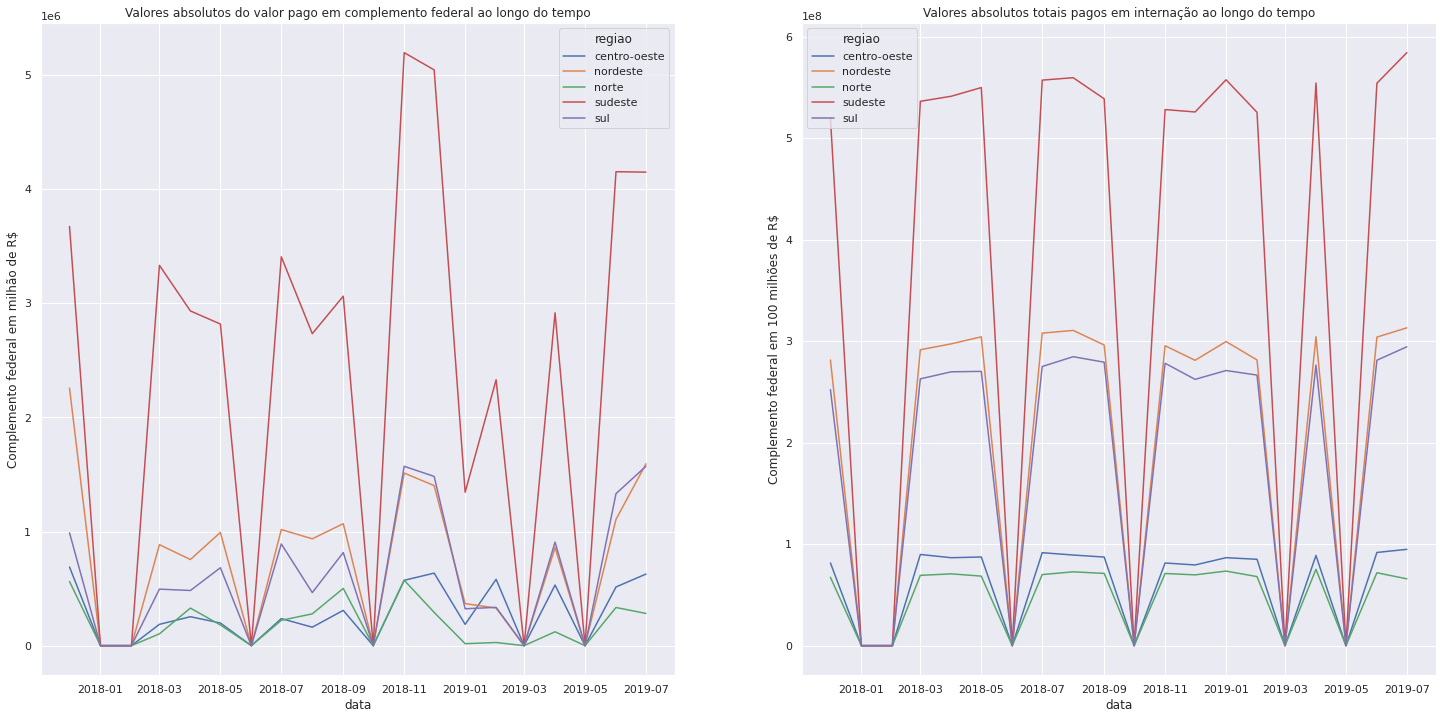

In [66]:
aux = df4[['data', 'valor_total', 'complemento_federal', 'regiao']].groupby(['data', 'regiao']).sum().reset_index()

plt.subplot(1,2,1)
sns.lineplot(x='data', y='complemento_federal', hue='regiao', data=aux)
plt.title('Valores absolutos do valor pago em complemento federal ao longo do tempo')
plt.ylabel('Complemento federal em milhão de R$')

plt.subplot(1,2,2)
sns.lineplot(x='data', y='valor_total', hue='regiao', data=aux)
plt.title('Valores absolutos totais pagos em internação ao longo do tempo')
plt.ylabel('Complemento federal em 100 milhões de R$')

Observações interessantes: pontos de máxima de valor total máximo não coincidem com os de máxima de complemento federal

### H3. A maior proporção dos complementos gestor em relação ao valor total pago deve estar na região sul.
**FALSA.** AA maior proporção dos complementos gestor em relação ao valor total pago está na região centro-oeste. 

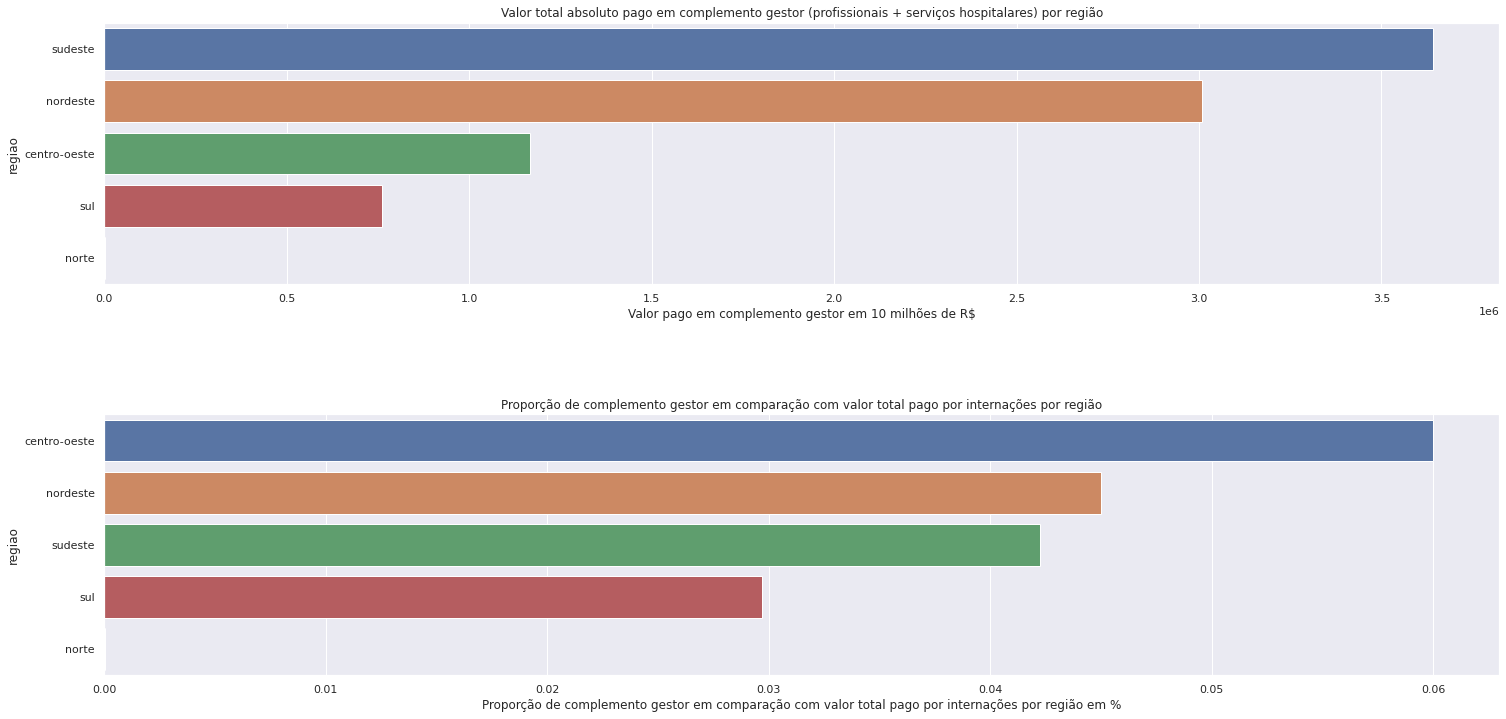

In [67]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    plt.subplot(2,1,1)
    aux1 = df4[['regiao', 'complemento_gestor']].groupby('regiao').sum().sort_values(by='complemento_gestor', ascending=False).reset_index()
    sns.barplot(x='complemento_gestor', y='regiao', data=aux1)
    plt.title('Valor total absoluto pago em complemento gestor (profissionais + serviços hospitalares) por região')
    plt.xlabel('Valor pago em complemento gestor em 10 milhões de R$')
    plt.subplots_adjust(hspace = 0.5)

    plt.subplot(2,1,2)
    aux2 = df4[['regiao', 'complemento_gestor', 'valor_total']]
    aux2['proporcao_complemento_gestor'] = (aux2['complemento_gestor'] / (aux2['complemento_gestor'] + aux2['valor_total']) )*100
    aux3 = aux2[['regiao', 'proporcao_complemento_gestor']].groupby('regiao').mean().sort_values(by='proporcao_complemento_gestor', ascending=False).reset_index()
    sns.barplot(x='proporcao_complemento_gestor', y='regiao', data=aux3)
    plt.title('Proporção de complemento gestor em comparação com valor total pago por internações por região')
    plt.xlabel('Proporção de complemento gestor em comparação com valor total pago por internações por região em %');

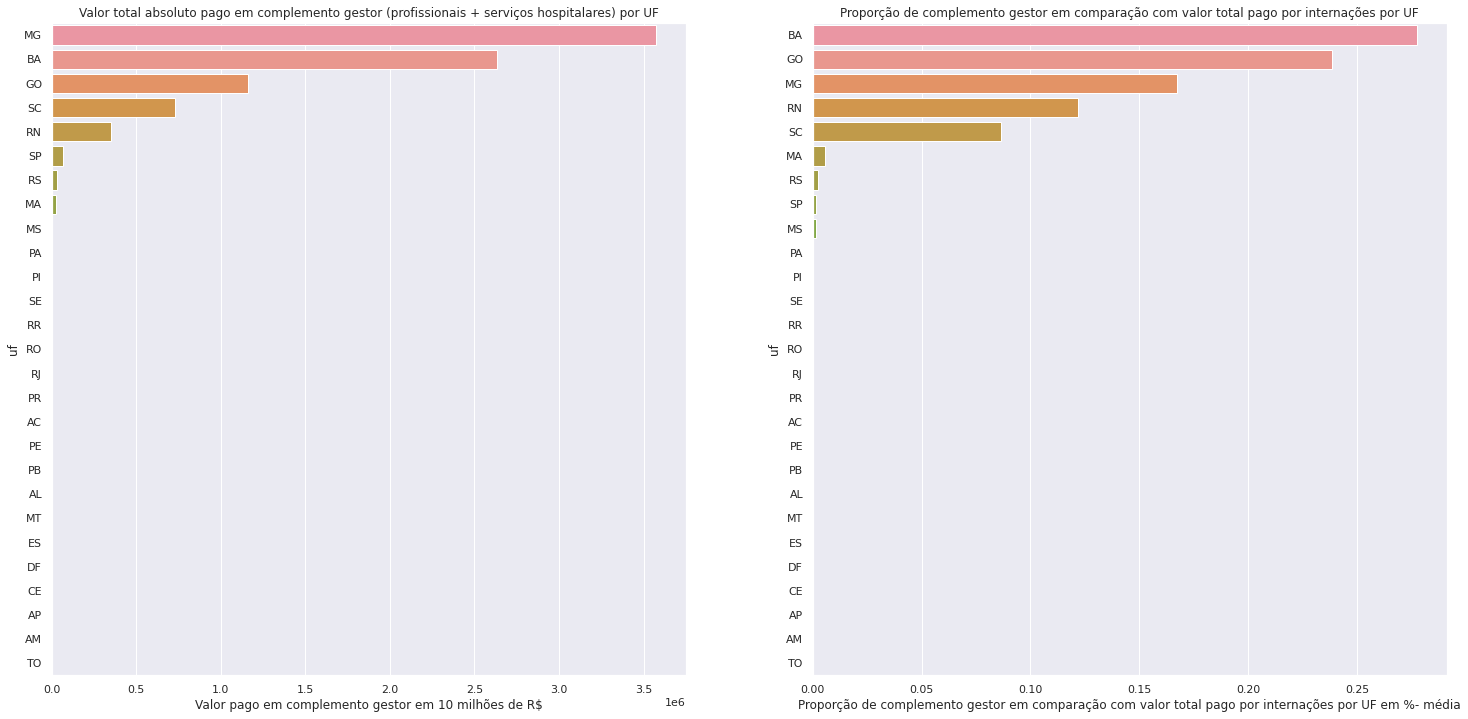

In [68]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    plt.subplot(1,2,1)
    aux1 = df4[['uf', 'complemento_gestor']].groupby('uf').sum().sort_values(by='complemento_gestor', ascending=False).reset_index()
    sns.barplot(x='complemento_gestor', y='uf', data=aux1)
    plt.title('Valor total absoluto pago em complemento gestor (profissionais + serviços hospitalares) por UF')
    plt.xlabel('Valor pago em complemento gestor em 10 milhões de R$')
    plt.subplots_adjust(hspace = 0.5)

    plt.subplot(1,2,2)
    aux2 = df4[['uf', 'complemento_gestor', 'valor_total']]
    aux2['proporcao_complemento_gestor'] = (aux2['complemento_gestor'] / (aux2['complemento_gestor'] + aux2['valor_total']) )*100
    aux3 = aux2[['uf', 'proporcao_complemento_gestor']].groupby('uf').mean().sort_values(by='proporcao_complemento_gestor', ascending=False).reset_index()
    sns.barplot(x='proporcao_complemento_gestor', y='uf', data=aux3)
    plt.title('Proporção de complemento gestor em comparação com valor total pago por internações por UF')
    plt.xlabel('Proporção de complemento gestor em comparação com valor total pago por internações por UF em %- média');

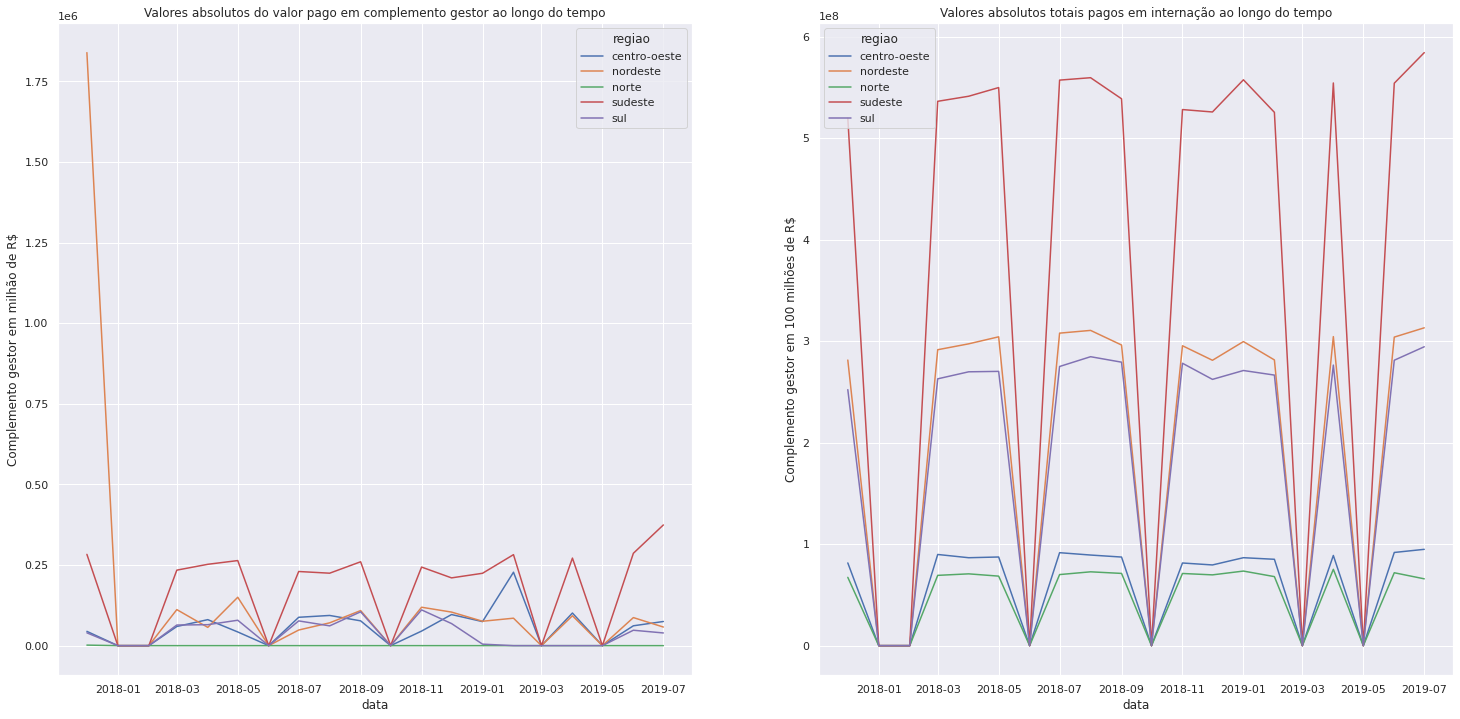

In [69]:
aux = df4[['data', 'valor_total', 'complemento_gestor', 'regiao']].groupby(['data', 'regiao']).sum().reset_index()

plt.subplot(1,2,1)
sns.lineplot(x='data', y='complemento_gestor', hue='regiao', data=aux)
plt.title('Valores absolutos do valor pago em complemento gestor ao longo do tempo')
plt.ylabel('Complemento gestor em milhão de R$')

plt.subplot(1,2,2)
sns.lineplot(x='data', y='valor_total', hue='regiao', data=aux)
plt.title('Valores absolutos totais pagos em internação ao longo do tempo')
plt.ylabel('Complemento gestor em 100 milhões de R$');

### H4. O valor médio por internação dos serviços profissionais deve ser maior na região Sudeste e Sul, respectivamente.
**FALSA.** O valor médio por internação dos serviços profissionais é maior na região Sul e Sudeste, respectivamente. Contudo, o estado com maior valor médio de serviços de profissionais é o Paraná

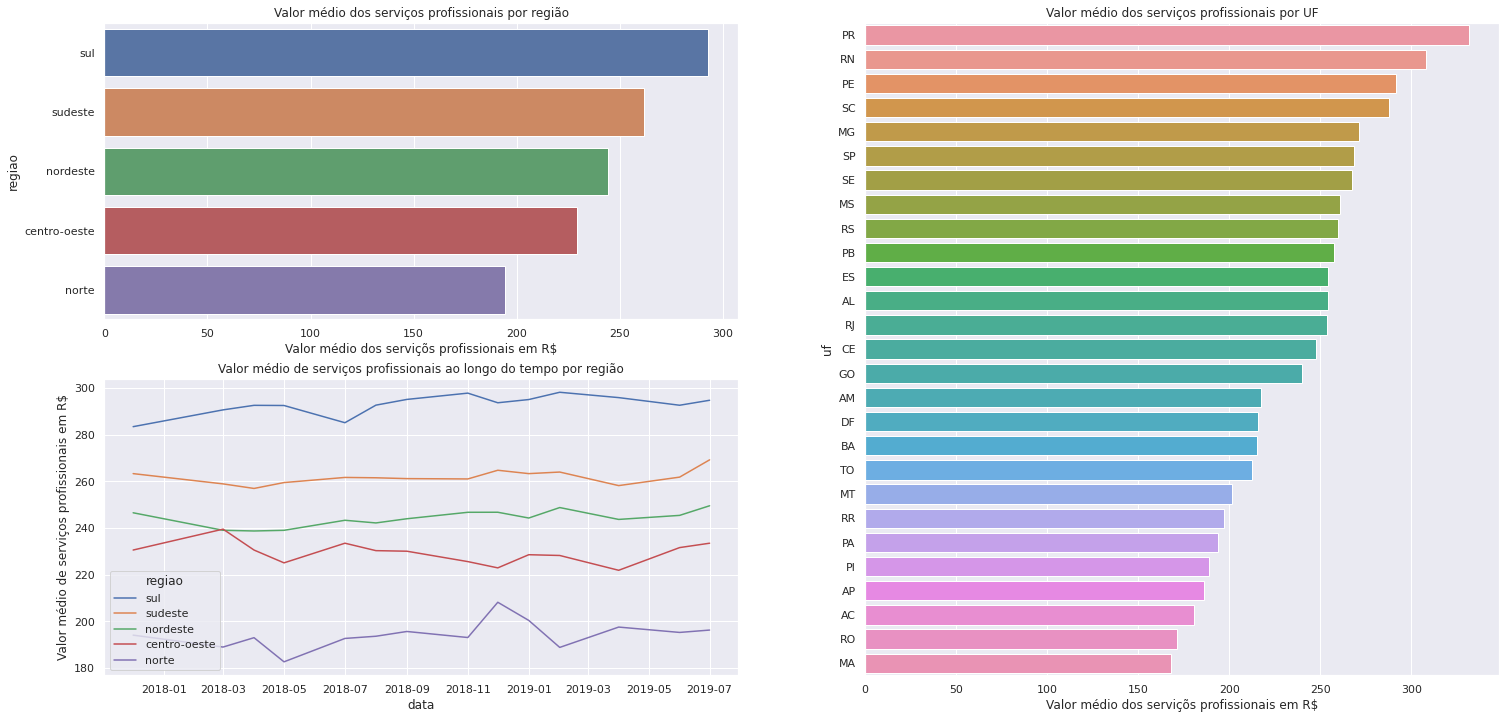

In [70]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    plt.subplot(2,2,1)
    aux = df4[['regiao', 'valor_serviços_profissionais', 'internacoes']]
    aux['valor_serv_prof_internacao'] = aux['valor_serviços_profissionais'] / aux['internacoes']
    aux = aux.groupby('regiao').mean().sort_values(by='valor_serv_prof_internacao', ascending=False).reset_index()
    sns.barplot(x='valor_serv_prof_internacao', y='regiao', data=aux)
    plt.title('Valor médio dos serviços profissionais por região')
    plt.xlabel('Valor médio dos serviçõs profissionais em R$');

    plt.subplot(2,2,(2,4))
    aux = df4[['uf', 'valor_serviços_profissionais', 'internacoes']]
    aux['valor_serv_prof_internacao'] = aux['valor_serviços_profissionais'] / aux['internacoes']
    aux = aux.groupby('uf').mean().sort_values(by='valor_serv_prof_internacao', ascending=False).reset_index()
    sns.barplot(x='valor_serv_prof_internacao', y='uf', data=aux)
    plt.title('Valor médio dos serviços profissionais por UF')
    plt.xlabel('Valor médio dos serviçõs profissionais em R$');

    plt.subplot(2,2,3)
    aux = df4[['data','regiao', 'valor_serviços_profissionais', 'internacoes']]
    aux['valor_serv_prof_internacao'] = aux['valor_serviços_profissionais'] / aux['internacoes']
    aux = aux.groupby(['data', 'regiao']).mean().sort_values(by='valor_serv_prof_internacao', ascending=False).reset_index()
    sns.lineplot(x='data', y='valor_serv_prof_internacao', hue='regiao', data=aux)
    plt.title('Valor médio de serviços profissionais ao longo do tempo por região')
    plt.ylabel('Valor médio de serviços profissionais em R$');

### H5. O maior número médio de leitos ocupados  deve estar na região Sudeste.
**VERDADEIRA.** O maior número médio de leitos ocupados está na região Sudeste

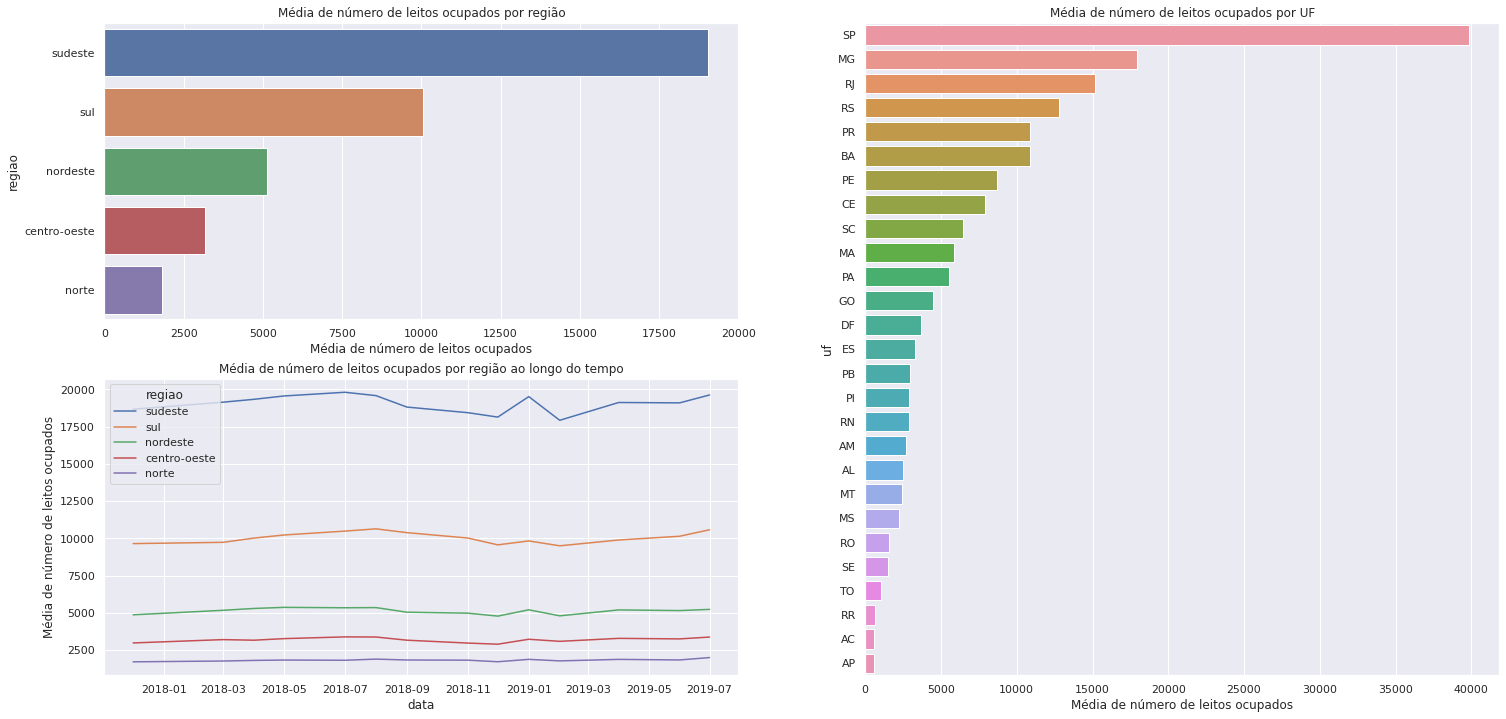

In [71]:
plt.subplot(2,2,1)
aux = df4[['regiao','uf', 'no_leitos_ocupado']].groupby('regiao').mean().sort_values(by='no_leitos_ocupado', ascending=False).reset_index()
sns.barplot(x='no_leitos_ocupado', y='regiao', data=aux)
plt.title('Média de número de leitos ocupados por região')
plt.xlabel('Média de número de leitos ocupados')

plt.subplot(2,2,(2,4))
aux = df4[['regiao','uf', 'no_leitos_ocupado']].groupby('uf').mean().sort_values(by='no_leitos_ocupado', ascending=False).reset_index()
sns.barplot(x='no_leitos_ocupado', y='uf', data=aux)
plt.title('Média de número de leitos ocupados por UF')
plt.xlabel('Média de número de leitos ocupados')


plt.subplot(2,2,3)
aux = df4[['data', 'regiao', 'no_leitos_ocupado']].groupby(['data', 'regiao']).mean().sort_values(by='no_leitos_ocupado', ascending=False).reset_index()
sns.lineplot(x='data', y='no_leitos_ocupado', hue='regiao', data=aux)
plt.title('Média de número de leitos ocupados por região ao longo do tempo')
plt.ylabel('Média de número de leitos ocupados');

### H6. A região sudeste é a que deve possuir mais leitos ocupados por habitante
**FALSO.** A região Sul é a que possui mais leitos ocupados por habitante, liderados pelo estado do Paraná

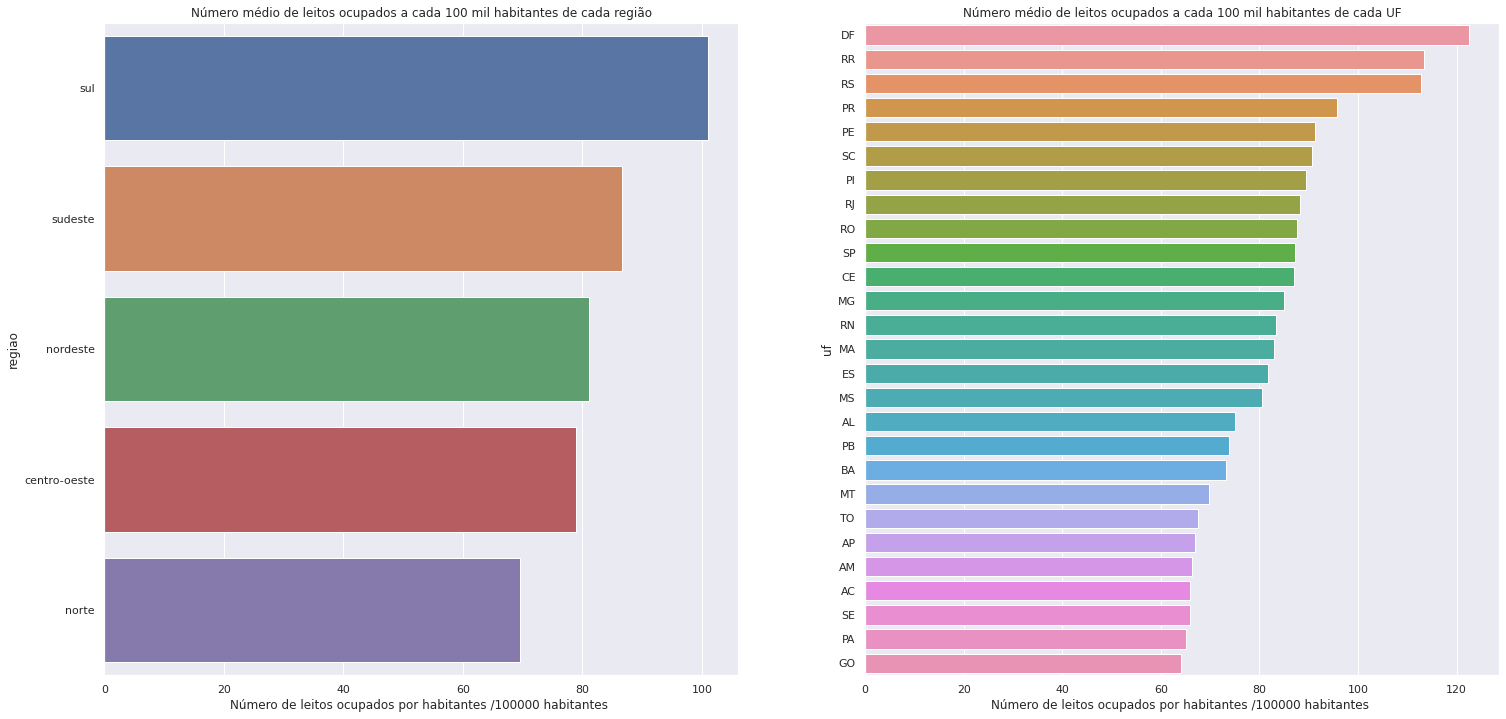

In [72]:
plt.subplot(1,2,1)
aux = df4[['no_leitos_ocupado', 'regiao', 'populacao']].groupby('regiao').mean().reset_index()
aux['no_leitos_pop'] = aux['no_leitos_ocupado'] / aux['populacao'] * 100000
aux = aux.sort_values(by='no_leitos_pop', ascending=False)
sns.barplot(x='no_leitos_pop', y='regiao', data=aux)
plt.title('Número médio de leitos ocupados a cada 100 mil habitantes de cada região')
plt.xlabel('Número de leitos ocupados por habitantes /100000 habitantes ');

plt.subplot(1,2,2)
aux = df4[['no_leitos_ocupado', 'uf', 'populacao']].groupby('uf').mean().reset_index()
aux['no_leitos_pop'] = aux['no_leitos_ocupado'] / aux['populacao'] * 100000
aux = aux.sort_values(by='no_leitos_pop', ascending=False)
sns.barplot(x='no_leitos_pop', y='uf', data=aux)
plt.title('Número médio de leitos ocupados a cada 100 mil habitantes de cada UF')
plt.xlabel('Número de leitos ocupados por habitantes /100000 habitantes ');

### H7. Os estados da região Norte devem ser os que possuem menos leitos ocupados por habitantes.
**VERDADEIRA.** Conforme visto em nas plotagens da H6. Porém RR e RO possuem ocupações bem acima da média do restante da região

### H8. O valor médio das internações pagas deve ser maior no estado de São Paulo e Distrito Federal, respectivamente 
**FALSA.** O valor médio das internações pagas é maior no estado do Paraná, Santa Catarina e Rio Grande do Sul, respectivamente. São Paulo e DF ocupam a 7a e 16a posição, respectivamente.

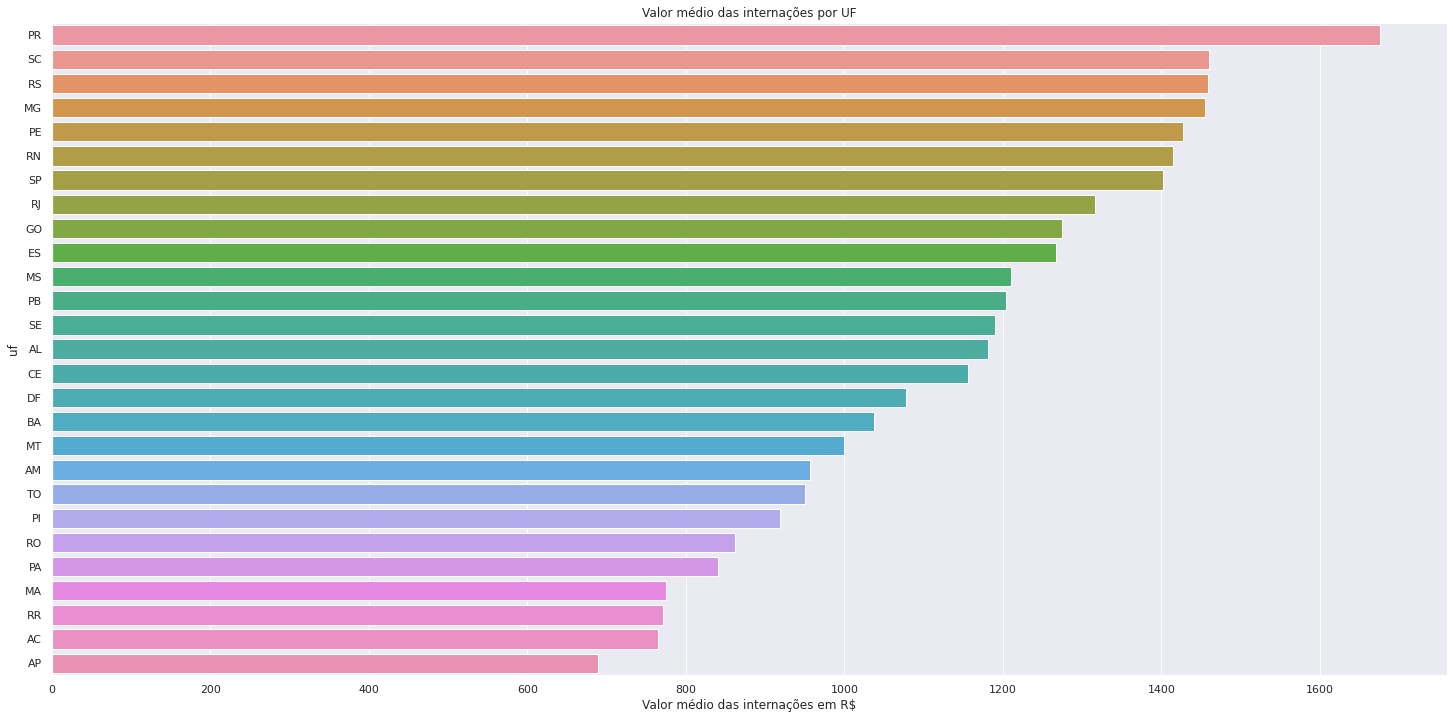

In [73]:
aux = df4[['valor_medio_intern', 'uf']].groupby('uf').mean().sort_values(by='valor_medio_intern', ascending=False).reset_index()
sns.barplot(y='uf', x='valor_medio_intern', data=aux)
plt.title('Valor médio das internações por UF')
plt.xlabel('Valor médio das internações em R$');

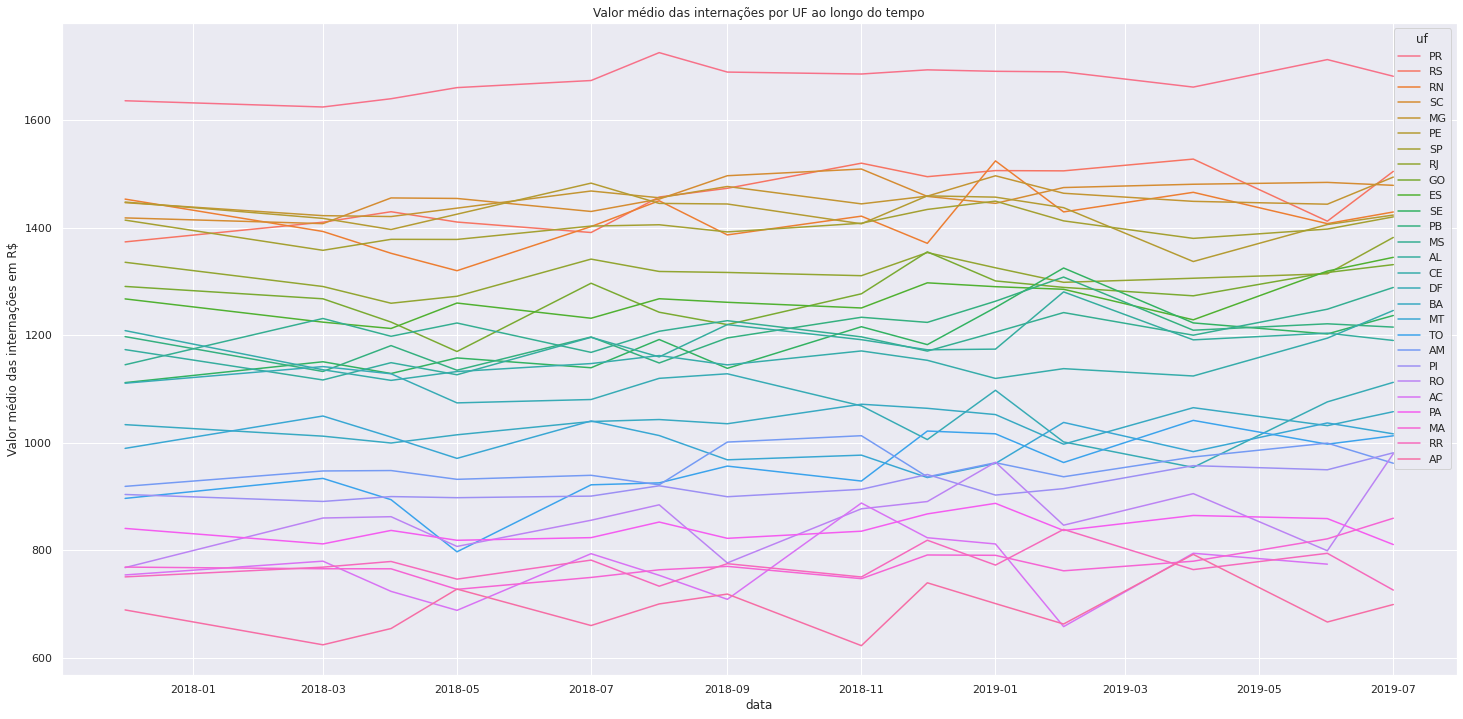

In [74]:
aux = df4[['data', 'valor_medio_intern', 'uf']].groupby(['data','uf']).mean().sort_values(by='valor_medio_intern', ascending=False).reset_index()
sns.lineplot(x='data', y='valor_medio_intern', hue='uf',data=aux)
plt.title('Valor médio das internações por UF ao longo do tempo')
plt.ylabel('Valor médio das internações em R$');

### H9. O tempo médio de permanência deve ser maior em estados do Nordeste 
**FALSA.** O tempo médio de permanência é maior na região Sudeste, com destaque para o Rio de Janeiro. Para quases todas as regiões há um aumento no tempo médio de permanência em janeiro e julho

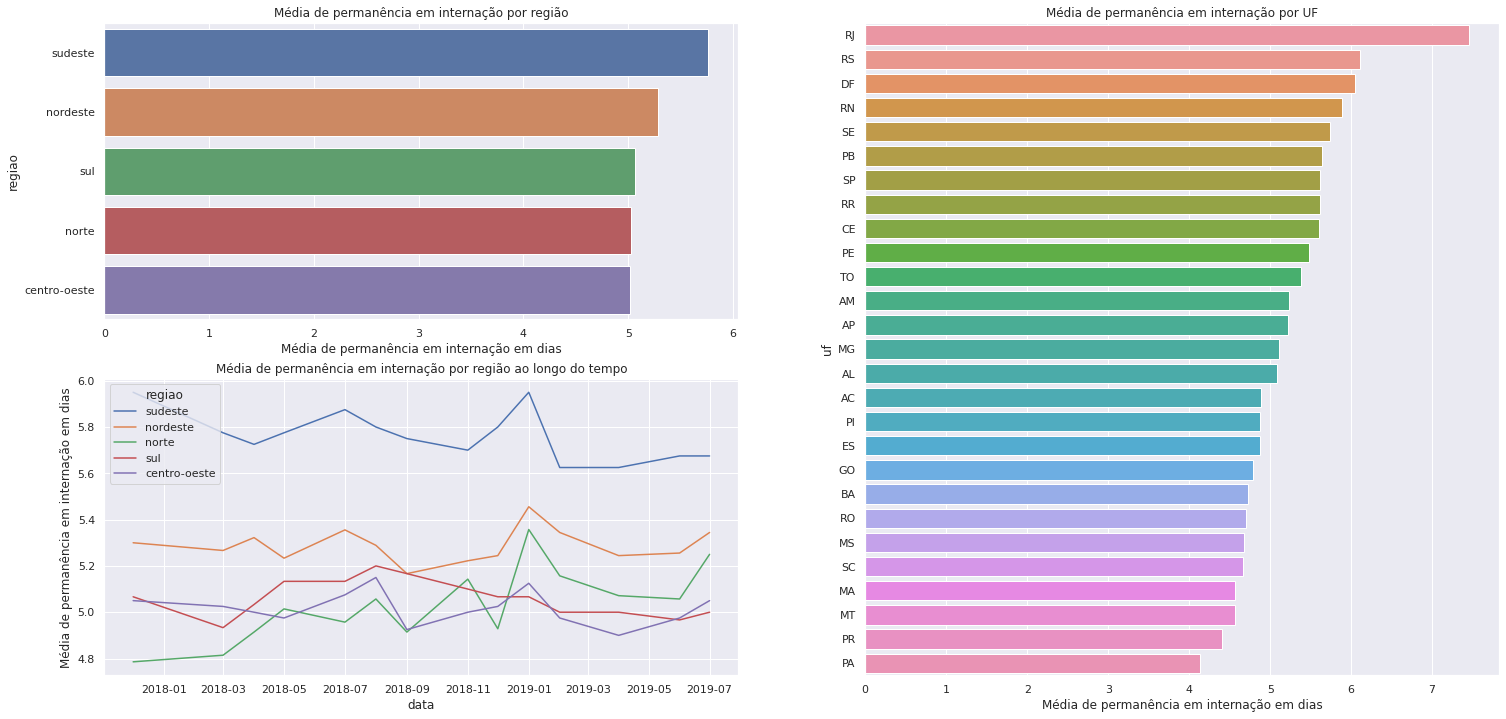

In [75]:
plt.subplot(2,2,1)
aux = df4[['regiao', 'media_permanencia']].groupby('regiao').mean().sort_values(by='media_permanencia', ascending=False).reset_index()
sns.barplot(x='media_permanencia', y='regiao', data=aux)
plt.title('Média de permanência em internação por região')
plt.xlabel('Média de permanência em internação em dias')

plt.subplot(2,2,(2,4))
aux = df4[['uf', 'media_permanencia']].groupby('uf').mean().sort_values(by='media_permanencia', ascending=False).reset_index()
sns.barplot(x='media_permanencia', y='uf', data=aux)
plt.title('Média de permanência em internação por UF')
plt.xlabel('Média de permanência em internação em dias');

plt.subplot(2,2,3)
aux = df4[['data', 'regiao', 'media_permanencia']].groupby(['data','regiao']).mean().sort_values(by='media_permanencia', ascending=False).reset_index()
sns.lineplot(x='data', y='media_permanencia', hue='regiao', data=aux)
plt.title('Média de permanência em internação por região ao longo do tempo')
plt.ylabel('Média de permanência em internação em dias');

### H10. A taxa de mortalidade deve ser maior em estados do Norte e Nordesete, respectivamente. 
**FALSA.** A taxa de mortalidade é maior em estados do Sudeste e Sul, respectivamente, com destaque para o Rio de Janeiro. <br>
Em agosto de 2018 a taxa de mortalidade de todas as regiões decaiu, exceto para região sul, que aumentou

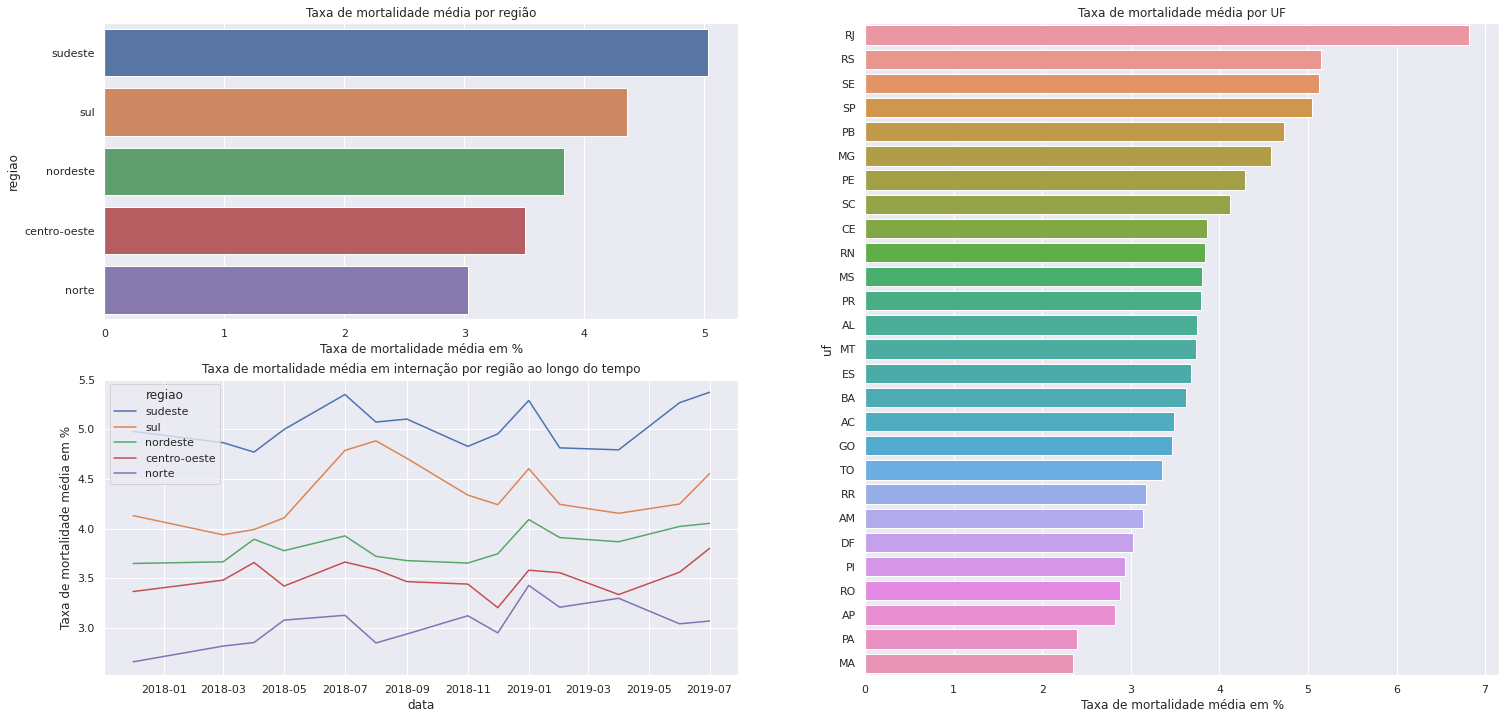

In [76]:
plt.subplot(2,2,1)
aux = df4[['regiao', 'taxa_mortalidade']].groupby('regiao').mean().sort_values(by='taxa_mortalidade', ascending=False).reset_index()
sns.barplot(x='taxa_mortalidade', y='regiao', data=aux)
plt.title('Taxa de mortalidade média por região')
plt.xlabel('Taxa de mortalidade média em %')

plt.subplot(2,2,(2,4))
aux = df4[['uf', 'taxa_mortalidade']].groupby('uf').mean().sort_values(by='taxa_mortalidade', ascending=False).reset_index()
sns.barplot(x='taxa_mortalidade', y='uf', data=aux)
plt.title('Taxa de mortalidade média por UF')
plt.xlabel('Taxa de mortalidade média em %')

plt.subplot(2,2,3)
aux = df4[['data', 'regiao', 'taxa_mortalidade']].groupby(['data','regiao']).mean().sort_values(by='taxa_mortalidade', ascending=False).reset_index()
sns.lineplot(x='data', y='taxa_mortalidade', hue='regiao', data=aux)
plt.title('Taxa de mortalidade média em internação por região ao longo do tempo')
plt.ylabel('Taxa de mortalidade média em %');

### H11. A região Sudeste deve concentrar o maior número de prorrogaões de internação que os outros estados.
**VERDADEIRA.** A região Sudeste concentra o maior número de prorrogações tanto em valor absoltuo quanto em proporção ao total de AIH aprovadas, com destaque para os estados de São Paulo e Rio de Janeiro. Alagoas também possui taxas bastante elevadas de prorrogações

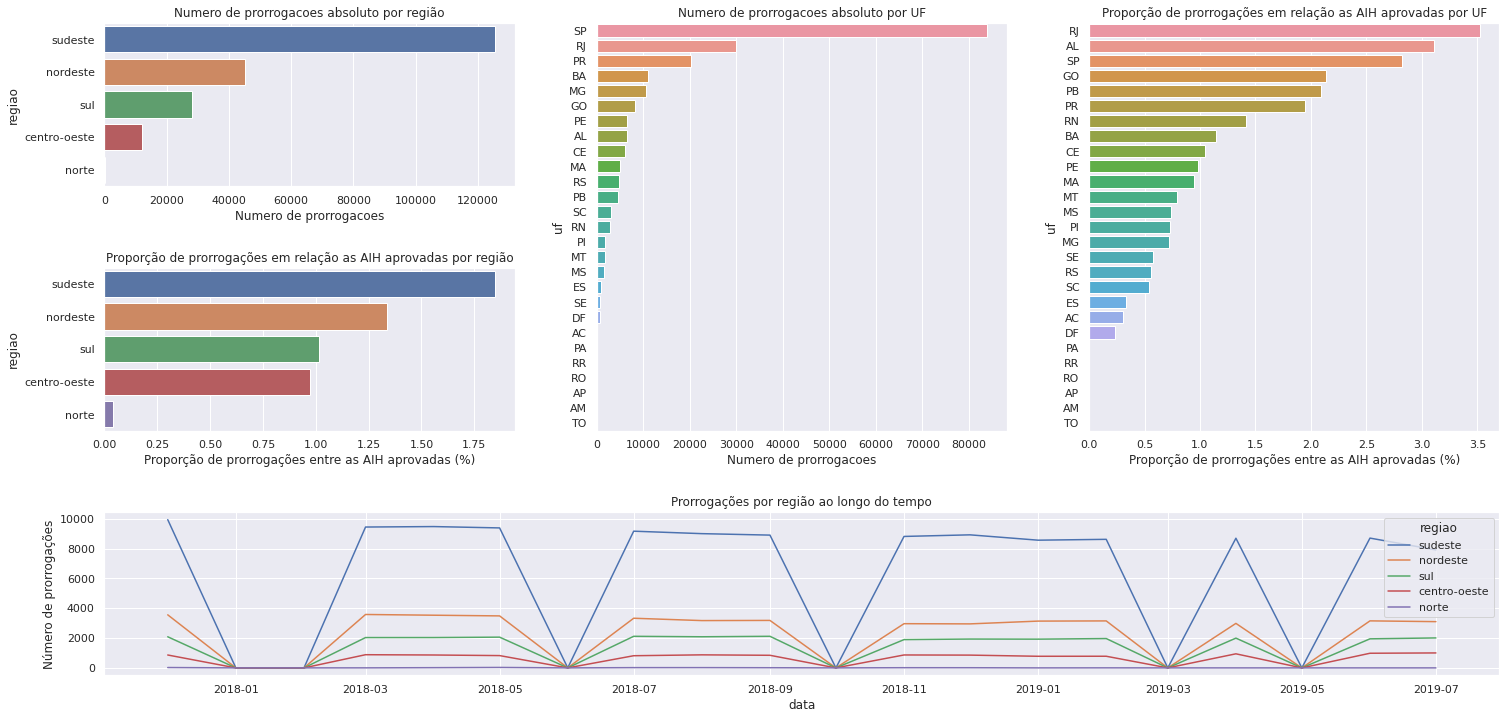

In [77]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    plt.subplot(3,3,1)
    aux=df4[['regiao', 'prorrogacoes']].groupby('regiao').sum().sort_values(by='prorrogacoes', ascending=False).reset_index()
    sns.barplot(x='prorrogacoes', y='regiao', data=aux)
    plt.title('Numero de prorrogacoes absoluto por região')
    plt.xlabel('Numero de prorrogacoes')

    plt.subplot(3,3,(2,5))
    aux=df4[['uf', 'prorrogacoes']].groupby('uf').sum().sort_values(by='prorrogacoes', ascending=False).reset_index()
    sns.barplot(x='prorrogacoes', y='uf', data=aux)
    plt.title('Numero de prorrogacoes absoluto por UF')
    plt.xlabel('Numero de prorrogacoes')
    plt.subplots_adjust(hspace = 0.5)

    plt.subplot(3,3,4)
    aux = df4[['regiao','aih_aprovadas', 'prorrogacoes']]
    aux['proporcao_prorrog'] = (aux['prorrogacoes'] / aux['aih_aprovadas'] *100)
    aux = aux.groupby('regiao').mean().sort_values(by='proporcao_prorrog', ascending=False).reset_index()
    sns.barplot(x='proporcao_prorrog', y='regiao', data=aux)
    plt.title('Proporção de prorrogações em relação as AIH aprovadas por região')
    plt.xlabel('Proporção de prorrogações entre as AIH aprovadas (%)');
    plt.subplots_adjust(hspace = 0.5)

    plt.subplot(3,3,(3,6))
    aux = df4[['uf','aih_aprovadas', 'prorrogacoes']]
    aux['proporcao_prorrog'] = (aux['prorrogacoes'] / aux['aih_aprovadas'] *100)
    aux = aux.groupby('uf').mean().sort_values(by='proporcao_prorrog', ascending=False).reset_index()
    sns.barplot(x='proporcao_prorrog', y='uf', data=aux)
    plt.title('Proporção de prorrogações em relação as AIH aprovadas por UF')
    plt.xlabel('Proporção de prorrogações entre as AIH aprovadas (%)');
    plt.subplots_adjust(hspace = 0.5)

    plt.subplot(3,3,(7,9))
    aux = df4[['data', 'regiao', 'prorrogacoes']].groupby(['data','regiao']).sum().sort_values(by='prorrogacoes', ascending=False).reset_index()
    sns.lineplot(x='data', y='prorrogacoes', hue='regiao', data=aux)
    plt.title('Prorrogações por região ao longo do tempo')
    plt.ylabel('Número de prorrogações');

### H12. O número médio de internações deve ser maior em meses de inverno para todos os estados do Brasil
**FALSO**. O número médio de internações é maior em meses de inverno para quase todos os estados, exceto para o Pará, Maranhão, Piauí e Rondônia. Para os estados em que se aplica, há um aumento médio de 5,52% no número de internações durante os meses de inverno, com destaque para Acre e Distrito Federal

In [78]:
inverno=['6', '7', '8', '9']
aux = df4[df4['mes'].isin(inverno)]
aux = aux[['internacoes', 'uf']].groupby('uf').mean().sort_values(by='internacoes', ascending=False).reset_index()
aux.columns=['uf', 'internacoes_inverno']

aux1 = df4[~df4['mes'].isin(inverno)]
aux1 = aux1[['internacoes', 'uf']].groupby('uf').mean().sort_values(by='internacoes', ascending=False).reset_index()

aux2 = aux.merge(aux1, on='uf')

aux2['diferenca_%'] = ((aux2['internacoes_inverno'] / aux2['internacoes']) -1)*100

In [79]:
aux2[aux2['diferenca_%'] < 0]

,uf,internacoes_inverno,internacoes,diferenca_%
9,PA,39978.200,40463.667,-1.200
10,MA,37206.200,38573.333,-3.544
14,PI,17831.600,17868.333,-0.206
21,RO,9764.200,9950.667,-1.874


In [80]:
aux2[aux2['diferenca_%'] >= 0]['diferenca_%'].mean()

5.529173965807318

In [81]:
aux2

,uf,internacoes_inverno,internacoes,diferenca_%
0,SP,209515.000,205628.444,1.890
1,MG,106950.600,103126.778,3.708
2,PR,74007.800,71987.778,2.806
3,BA,70723.200,66991.000,5.571
4,RS,65064.600,61036.667,6.599
5,RJ,60969.200,57633.556,5.788
6,PE,48113.000,46457.444,3.564
7,SC,42975.200,40192.778,6.923
8,CE,41987.200,41849.000,0.330
9,PA,39978.200,40463.667,-1.200


### H13. O tempo médio de internação deve ser maior nos meses de inverno
**FALSA.** O tempo médio de internação é menor nos meses de inverno para 10 dos 26 estados. Para os estados em que se aplica, há um aumento de apenas 1,42% no tempo médio de permanência. 

In [82]:
df4.columns

Index(['data', 'mes', 'ano', 'uf', 'regiao', 'internacoes', 'prorrogacoes',
       'aih_aprovadas', 'valor_total', 'complemento_federal',
       'complemento_gestor', 'valor_serviços_profissionais',
       'valor_medio_intern', 'valor_medio_aih', 'no_leitos_ocupado', 'obitos',
       'taxa_mortalidade', 'populacao', 'media_permanencia'],
      dtype='object')

In [83]:
aux = df4[df4['mes'].isin(inverno)]
aux = aux[['media_permanencia', 'uf']].groupby('uf').mean().sort_values(by='media_permanencia', ascending=False).reset_index()
aux.columns=['uf', 'media_permanencia_inverno']

aux1 = df4[~df4['mes'].isin(inverno)]
aux1 = aux1[['media_permanencia', 'uf']].groupby('uf').mean().sort_values(by='media_permanencia', ascending=False).reset_index()

aux2 = aux.merge(aux1, on='uf')

aux2['diferenca_%'] = ((aux2['media_permanencia_inverno'] / aux2['media_permanencia']) -1)*100

In [84]:
aux2[aux2['diferenca_%'] < 0]

,uf,media_permanencia_inverno,media_permanencia,diferenca_%
0,RJ,7.400,7.489,-1.187
2,DF,6.020,6.056,-0.587
3,RN,5.860,5.900,-0.678
5,SE,5.620,5.800,-3.103
6,SP,5.600,5.622,-0.395
7,PB,5.580,5.667,-1.529
11,RR,5.320,5.778,-7.923
14,AL,5.060,5.089,-0.568
17,AC,4.875,4.900,-0.510
21,BA,4.700,4.744,-0.937


In [85]:
aux2[aux2['diferenca_%'] >= 0]['diferenca_%'].mean()

1.4210004870622783

In [86]:
aux2

,uf,media_permanencia_inverno,media_permanencia,diferenca_%
0,RJ,7.400,7.489,-1.187
1,RS,6.180,6.078,1.682
2,DF,6.020,6.056,-0.587
3,RN,5.860,5.900,-0.678
4,CE,5.680,5.567,2.036
5,SE,5.620,5.800,-3.103
6,SP,5.600,5.622,-0.395
7,PB,5.580,5.667,-1.529
8,PE,5.500,5.478,0.406
9,TO,5.460,5.344,2.162


### H14. O comportamento das internações no tempo deve ser igual para todos os estados do Brasil
**VERDADEIRA.** O comportamento das internações no tempo (crescimentos e declínios é igual para todos os estados do Brasil

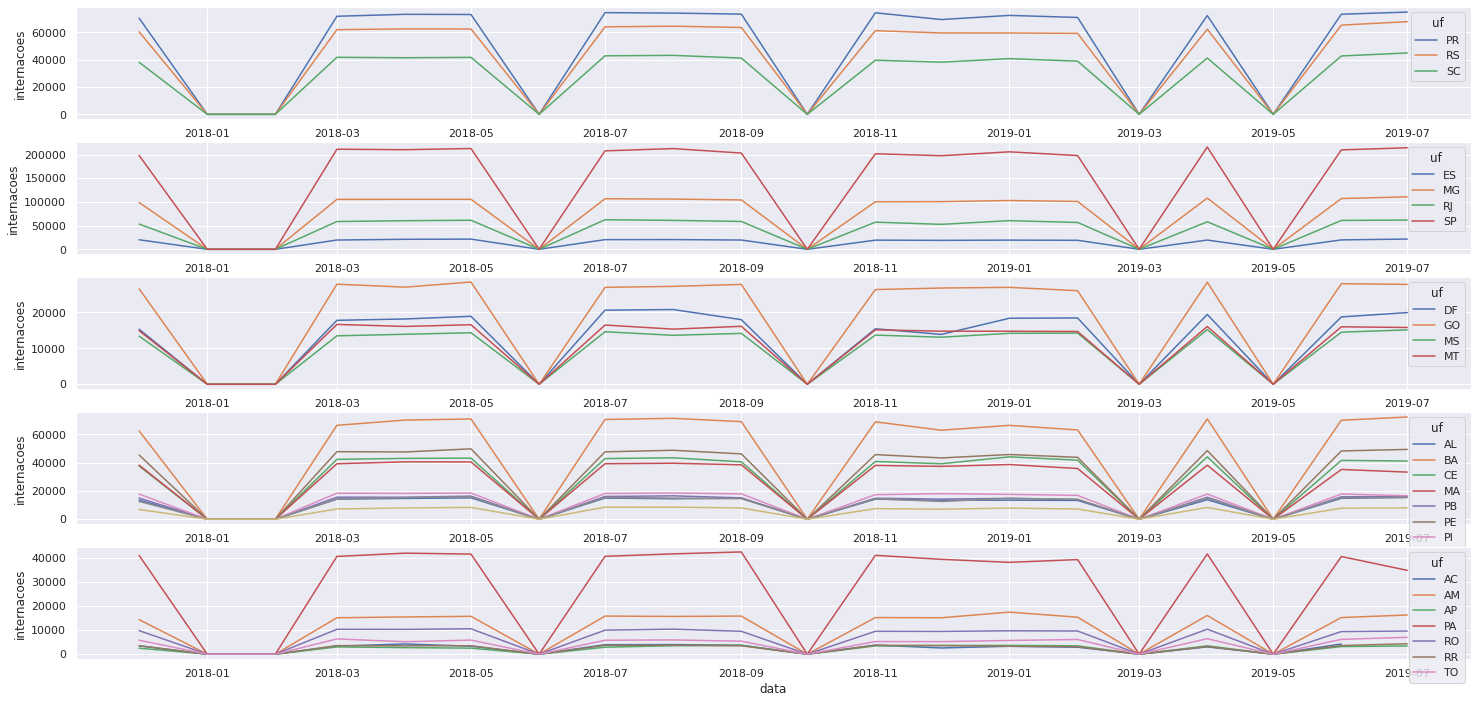

In [87]:
plt.title('Evolução do número de internações por UF e região')

plt.subplot(5,1,1)
aux = df4[['data', 'regiao', 'uf', 'internacoes']].groupby(['data','regiao', 'uf']).sum().reset_index()
aux = aux[aux['regiao'] == 'sul']
sns.lineplot(x='data', y='internacoes', hue='uf', data=aux)


plt.subplot(5,1,2)
aux = df4[['data', 'regiao', 'uf', 'internacoes']].groupby(['data','regiao', 'uf']).sum().reset_index()
aux = aux[aux['regiao'] == 'sudeste']
sns.lineplot(x='data', y='internacoes', hue='uf', data=aux)

plt.subplot(5,1,3)
aux = df4[['data', 'regiao', 'uf', 'internacoes']].groupby(['data','regiao', 'uf']).sum().reset_index()
aux = aux[aux['regiao'] == 'centro-oeste']
sns.lineplot(x='data', y='internacoes', hue='uf', data=aux)

plt.subplot(5,1,4)
aux = df4[['data', 'regiao', 'uf', 'internacoes']].groupby(['data','regiao', 'uf']).sum().reset_index()
aux = aux[aux['regiao'] == 'nordeste']
sns.lineplot(x='data', y='internacoes', hue='uf', data=aux)

plt.subplot(5,1,5)
aux = df4[['data', 'regiao', 'uf', 'internacoes']].groupby(['data','regiao', 'uf']).sum().reset_index()
aux = aux[aux['regiao'] == 'norte']
sns.lineplot(x='data', y='internacoes', hue='uf', data=aux);

## RESUMO DOS PRINCIPAIS INSIGHTS

- A região Sudeste, por ser a mais populosa do país, concentra o maior número absoluto de internações e, consequentemente, com gastos para pagamentos das internações (mais de 50% do valor total gasto em internações do Brasil são de São Paulo);
- A região Sudeste é a que mais tem repasses do governo global para complemento de pagamentos de serviços hospitalares e profissionais da saúde. Porém Goiás, Bahia e Rio de Janeiro são os que mais recebem complementos federais em relação aos valores totais das internações. Interessante perceber que os meses cuja média de complementos federais são maiores não correspondem aos meses em que os valores totais são maiores;
- A região centro-oeste é a que tem mais repasses do gestor (estadual ou municipal) comparado com o valor total, com destaque novamente para o Goiás;
- Em dezembro de 2017 a região nordeste teve um grande repasse dos gestores;
- A região Sul é a que tem o maior valor médio gasto por internação, com destaque para o Paraná;
- A região Sul é a que tem mais leitos ocupados por 100 mil habitantes. Essa informação deve ser comparada com a disponibilidade de leitos para melhor planejamento estratégico; 
- O tempo médio de permanência em internação é maior na região sudeste, com destaque para o Rio de Janeiro;
- A taxa de mortalidade é maior na região Sudeste, com destaque ṕara o Rio de Janeiro;
- São Paulo, Rio de Janeiro e Alagoas apresentam elevada taxa de prorrogração de internações;
- Durante o inverno, há um aumento no número médio de internações para alguns estados, assim como no tempo médio de internação;
- Todos os estados tem comportamento semelhante do número de internações no tempo

<p><b>Conclusão:</b> Além do número de internações, é preciso observar outros aspectos da gestão. Algumas perguntas para investigações mais profundas podem ser feitas, como por exemplo:
    
    - Por que no Rio de Janeiro tanto o tempo de internação quanto o número de prorrogações e taxa de mortalidade são mais altos? Os casos são mais complexos? Há equipamentos suficientes para atender a população?
    - Por que a região sul tem um valor médio pago por internação maiores? Complexidade dos procedimentos?
    - Por que em agosto de 2018 a taxa de mortalidade média caiu em todas as regiões, exceto na região sul?
    - Quais as possíveis causas da média do número de internações aumentar nos meses de inverno? 
    
    


# 5.0 Preparação dos dados

In [88]:
df5 = df4.copy()

In [89]:
#duas maneiras (existem várias) -- média móvel, autoregressão, trazer o próximo valor, média do dataset

## 5.1 Imputação de dados com a média móvel

In [90]:
df5.head()

,data,mes,ano,uf,regiao,internacoes,prorrogacoes,aih_aprovadas,valor_total,complemento_federal,complemento_gestor,valor_serviços_profissionais,valor_medio_intern,valor_medio_aih,no_leitos_ocupado,obitos,taxa_mortalidade,populacao,media_permanencia
0,2017-12-01,12,2017,RN,nordeste,12602.000,218.000,12820.000,18311840.010,0.000,0.000,4036658.280,1453.090,1428.380,2521.267,515.000,4.090,3507003.000,5.900
1,2018-01-01,1,2018,RN,nordeste,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3479010.000,NaN
2,2018-02-01,2,2018,RN,nordeste,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3479010.000,NaN
3,2018-03-01,3,2018,RN,nordeste,14246.000,219.000,14465.000,19842834.930,0.000,0.000,4361564.240,1392.870,1371.780,2748.350,527.000,3.700,3479010.000,5.700
4,2018-04-01,4,2018,RN,nordeste,15363.000,213.000,15576.000,20774806.620,0.000,0.000,4585141.130,1352.260,1333.770,3115.200,594.000,3.870,3479010.000,6.000


In [91]:
df_media_movel = pd.DataFrame(columns=df5.columns)
uf = list(df5['uf'].unique())

for i in range(0,len(uf)):
    df_uf = df5.loc[df5['uf'] == uf[i]]
    df_uf = df_uf.fillna(df_uf[['internacoes', 'valor_total', 'valor_medio_aih', 'obitos']].rolling(6, min_periods=0).mean())
    df_media_movel = pd.concat([df_media_movel,df_uf])
#df_teste = df5.loc[df5['uf'] == 'SP']

<AxesSubplot:xlabel='data', ylabel='internacoes'>

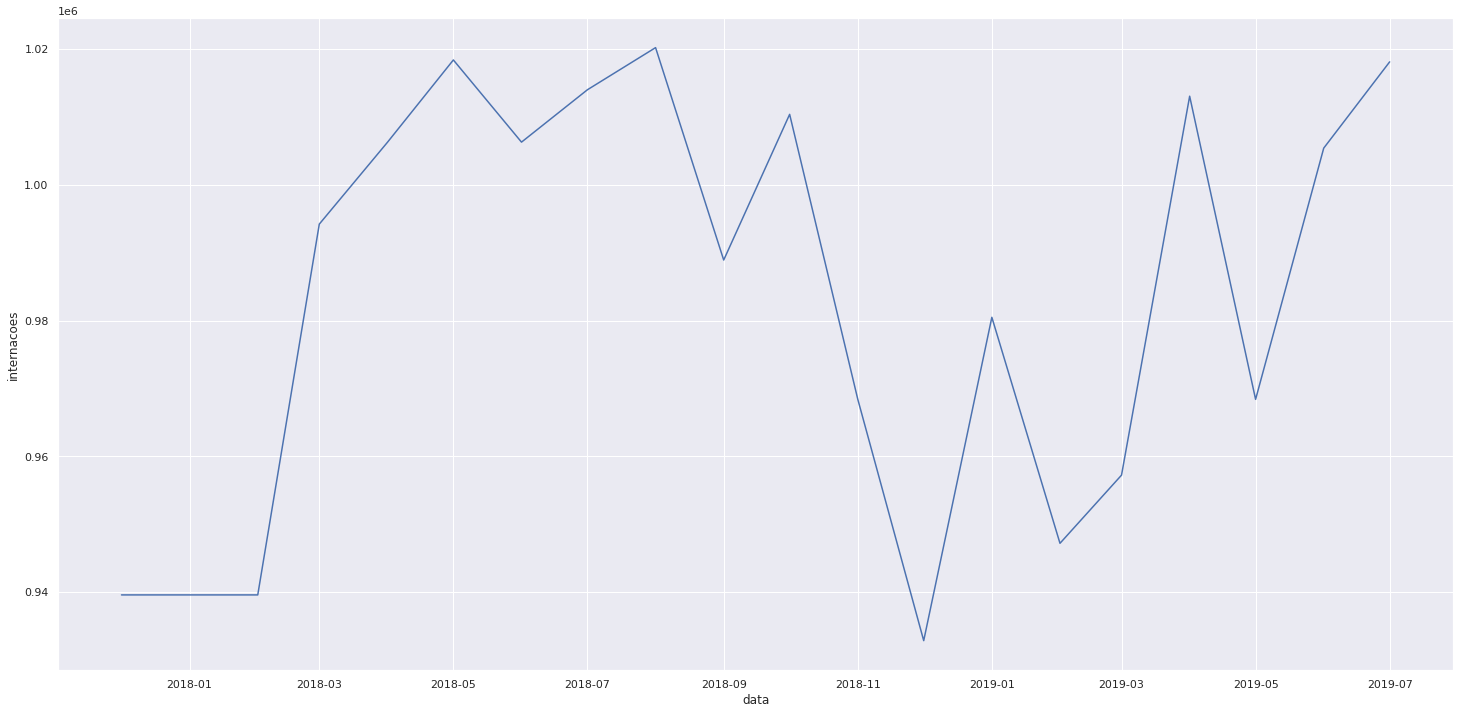

In [92]:
sns.lineplot(x='data', y='internacoes', data=df_media_movel.groupby('data').sum().reset_index())

# 6.0 Modelagem dos dados

In [93]:
df6 = df_media_movel[['data', 'internacoes', 'obitos']].groupby('data').sum().reset_index()
df6.head()

,data,internacoes,obitos
0,2017-12-01,939601.000,38881.000
1,2018-01-01,939601.000,38881.000
2,2018-02-01,939601.000,38881.000
3,2018-03-01,994222.000,40490.000
4,2018-04-01,1006271.000,41111.000


## 6.1 Internações

In [94]:
df6_internacoes = df6[['data','internacoes']]

df6_internacoes.index = df6_internacoes['data']
df6_internacoes = df6_internacoes.drop(columns=['data'])

df6_internacoes.head()

#teste de estacionariedade
dftest = adfuller(df6_internacoes, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Teste', 'Valor p', 'No de lags', 'No de observações'])
dfoutput



stepwise_model = auto_arima(df6_internacoes, start_p=1, start_q=1, max_q=6, m=6, seasonal=True, d=1, D=1, trace=True, error_action='ignore',
                            suppress_warnings=True, stepwise=True)

print(stepwise_model.aic())

train = df6_internacoes.loc['2017-12-01':'2019-02-01']
test = df6_internacoes.loc['2019-02-01':]

stepwise_model.fit(train)

future_forecast = stepwise_model.predict(n_periods=6)


future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['internacoes'])
df6_internacoes_prev = pd.concat([test,future_forecast],axis=1)

df6_internacoes_prev.columns = ['real', 'previsto']
df6_internacoes_prev['erro absoluto'] = df6_internacoes_prev['previsto'] - df6_internacoes_prev['real'] 
df6_internacoes_prev['erro percentual'] = ( df6_internacoes_prev['previsto'] - df6_internacoes_prev['real'] ) / df6_internacoes_prev['real'] *100
MAPE = df6_internacoes_prev['erro percentual'].mean()
print(MAPE)

df6_internacoes_prev

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[6]             : AIC=inf, Time=0.30 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=316.949, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=319.857, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=319.955, Time=0.02 sec
 ARIMA(0,1,0)(1,1,0)[6]             : AIC=318.510, Time=0.01 sec
 ARIMA(0,1,0)(0,1,1)[6]             : AIC=317.982, Time=0.01 sec
 ARIMA(0,1,0)(1,1,1)[6]             : AIC=inf, Time=0.06 sec
 ARIMA(1,1,0)(0,1,0)[6]             : AIC=317.929, Time=0.01 sec
 ARIMA(0,1,1)(0,1,0)[6]             : AIC=318.056, Time=0.01 sec
 ARIMA(1,1,1)(0,1,0)[6]             : AIC=320.059, Time=0.02 sec
 ARIMA(0,1,0)(0,1,0)[6] intercept   : AIC=318.000, Time=0.00 sec

Best model:  ARIMA(0,1,0)(0,1,0)[6]          
Total fit time: 0.507 seconds
316.94898601818255
-8.680439332295581


,real,previsto,erro absoluto,erro percentual
data,,,,
2019-02-01,947202.000,915913.000,-31289.000,-3.303
2019-03-01,957246.000,937375.000,-19871.000,-2.076
2019-04-01,1013065.000,895405.000,-117660.000,-11.614
2019-05-01,968406.500,859845.000,-108561.500,-11.210
2019-06-01,1005416.000,907478.000,-97938.000,-9.741
2019-07-01,1018125.000,874184.000,-143941.000,-14.138


## 6.2 Óbitos

In [95]:
df6_obitos = df6[['data','obitos']]

df6_obitos.index = df6_obitos['data']
df6_obitos = df6_obitos.drop(columns=['data'])

df6_obitos.head()

#teste de estacionariedade
dftest = adfuller(df6_obitos, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Teste', 'Valor p', 'No de lags', 'No de observações'])
dfoutput



stepwise_model = auto_arima(df6_obitos, start_p=1, start_q=1, max_q=6, m=6, seasonal=True, d=1, D=1, trace=True, error_action='ignore',
                            suppress_warnings=True, stepwise=True)

print(stepwise_model.aic())

train = df6_obitos.loc['2017-12-01':'2019-02-01']
test = df6_obitos.loc['2019-02-01':]

stepwise_model.fit(train)

future_forecast = stepwise_model.predict(n_periods=6)


future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['obitos'])
df6_obitos_prev = pd.concat([test,future_forecast],axis=1)

df6_obitos_prev.columns = ['real', 'previsto']
df6_obitos_prev['erro absoluto'] = df6_obitos_prev['previsto'] - df6_obitos_prev['real'] 
df6_obitos_prev['erro percentual'] = ( df6_obitos_prev['previsto'] - df6_obitos_prev['real'] ) / df6_obitos_prev['real'] *100
MAPE = df6_obitos_prev['erro percentual'].mean()
print(MAPE)

df6_obitos_prev

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[6]             : AIC=250.658, Time=0.14 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=246.631, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=247.951, Time=0.03 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=248.364, Time=0.03 sec
 ARIMA(0,1,0)(1,1,0)[6]             : AIC=248.778, Time=0.02 sec
 ARIMA(0,1,0)(0,1,1)[6]             : AIC=248.384, Time=0.02 sec
 ARIMA(0,1,0)(1,1,1)[6]             : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,1,0)[6]             : AIC=246.056, Time=0.02 sec
 ARIMA(1,1,0)(0,1,1)[6]             : AIC=247.911, Time=0.03 sec
 ARIMA(1,1,0)(1,1,1)[6]             : AIC=inf, Time=0.19 sec
 ARIMA(2,1,0)(0,1,0)[6]             : AIC=248.153, Time=0.02 sec
 ARIMA(1,1,1)(0,1,0)[6]             : AIC=248.210, Time=0.04 sec
 ARIMA(0,1,1)(0,1,0)[6]             : AIC=246.477, Time=0.01 sec
 ARIMA(2,1,1)(0,1,0)[6]             : AIC=248.702, Time=0.03 sec
 ARIMA(1,1,0)(0,1,0)[6] intercept   : AIC=247.901, Time

,real,previsto,erro absoluto,erro percentual
data,,,,
2019-02-01,39496.000,38157.584,-1338.416,-3.389
2019-03-01,40751.000,39213.857,-1537.143,-3.772
2019-04-01,41806.000,35457.732,-6348.268,-15.185
2019-05-01,41183.000,34659.489,-6523.511,-15.840
2019-06-01,44477.000,39527.658,-4949.342,-11.128
2019-07-01,46924.000,34874.635,-12049.365,-25.678


## 6.3 Valor médio por AIH

In [96]:
df6_valor_medio_aih = df_media_movel[['data', 'valor_medio_aih']].groupby('data').mean()

df6_valor_medio_aih.head()

#teste de estacionariedade
dftest = adfuller(df6_valor_medio_aih, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Teste', 'Valor p', 'No de lags', 'No de observações'])
dfoutput



stepwise_model = auto_arima(df6_valor_medio_aih, start_p=1, start_q=1, max_q=6, m=6, seasonal=True, d=1, D=1, trace=True, error_action='ignore',
                            suppress_warnings=True, stepwise=True)

print(stepwise_model.aic())

train = df6_valor_medio_aih.loc['2017-12-01':'2019-02-01']
test = df6_valor_medio_aih.loc['2019-02-01':]

stepwise_model.fit(train)

future_forecast = stepwise_model.predict(n_periods=6)


future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['valor_medio_aih'])
df6_valor_medio_aih_prev = pd.concat([test,future_forecast],axis=1)

df6_valor_medio_aih_prev.columns = ['real', 'previsto']
df6_valor_medio_aih_prev['erro absoluto'] = df6_valor_medio_aih_prev['previsto'] - df6_valor_medio_aih_prev['real'] 
df6_valor_medio_aih_prev['erro percentual'] = ( df6_valor_medio_aih_prev['previsto'] - df6_valor_medio_aih_prev['real'] ) / df6_valor_medio_aih_prev['real'] *100
MAPE = df6_valor_medio_aih_prev['erro percentual'].mean()
print(MAPE)

df6_valor_medio_aih_prev

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[6]             : AIC=103.047, Time=0.34 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=108.640, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=106.066, Time=0.02 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=110.242, Time=0.03 sec
 ARIMA(1,1,1)(0,1,1)[6]             : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(1,1,0)[6]             : AIC=101.547, Time=0.08 sec
 ARIMA(1,1,1)(0,1,0)[6]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,1)(2,1,0)[6]             : AIC=102.812, Time=0.38 sec
 ARIMA(1,1,1)(2,1,1)[6]             : AIC=104.817, Time=0.52 sec
 ARIMA(0,1,1)(1,1,0)[6]             : AIC=107.366, Time=0.04 sec
 ARIMA(2,1,1)(1,1,0)[6]             : AIC=103.164, Time=0.12 sec
 ARIMA(1,1,2)(1,1,0)[6]             : AIC=101.715, Time=0.11 sec
 ARIMA(0,1,0)(1,1,0)[6]             : AIC=107.112, Time=0.01 sec
 ARIMA(0,1,2)(1,1,0)[6]             : AIC=109.128, Time=0.02 sec
 ARIMA(2,1,0)(1,1,0)[6]             : AIC=106.084, Time

,real,previsto,erro absoluto,erro percentual
data,,,,
2019-02-01,1136.357,1144.799,8.442,0.743
2019-03-01,1140.126,1127.066,-13.060,-1.146
2019-04-01,1133.459,1130.674,-2.784,-0.246
2019-05-01,1140.122,1125.518,-14.605,-1.281
2019-06-01,1138.843,1159.757,20.914,1.836
2019-07-01,1175.484,1152.655,-22.829,-1.942


# 7.0 Previsões e avaliações finais

In [97]:
df7 = df_media_movel[['data', 'internacoes', 'obitos']].groupby('data').sum().reset_index()
df7.head()

,data,internacoes,obitos
0,2017-12-01,939601.000,38881.000
1,2018-01-01,939601.000,38881.000
2,2018-02-01,939601.000,38881.000
3,2018-03-01,994222.000,40490.000
4,2018-04-01,1006271.000,41111.000


## 7.1 Internações

In [98]:
data_prev = ['2019-08-01', '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01']

In [99]:
df7_internacoes = df7[['data','internacoes']]

df7_internacoes.index = df7_internacoes['data']
df7_internacoes = df7_internacoes.drop(columns=['data'])

df7_internacoes.head()

#teste de estacionariedade
dftest = adfuller(df7_internacoes, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Teste', 'Valor p', 'No de lags', 'No de observações'])
dfoutput



stepwise_model = auto_arima(df7_internacoes, start_p=1, start_q=1, max_q=6, m=6, seasonal=True, d=1, D=1, trace=True, error_action='ignore',
                            suppress_warnings=True, stepwise=True)

print(stepwise_model.aic())

stepwise_model.fit(df7_internacoes)

future_forecast = stepwise_model.predict(n_periods=6)


future_forecast_int = pd.DataFrame(future_forecast, index=data_prev, columns=['previsao_internacoes'])

future_forecast_int

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[6]             : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=316.949, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=319.857, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=319.955, Time=0.04 sec
 ARIMA(0,1,0)(1,1,0)[6]             : AIC=318.510, Time=0.03 sec
 ARIMA(0,1,0)(0,1,1)[6]             : AIC=317.982, Time=0.02 sec
 ARIMA(0,1,0)(1,1,1)[6]             : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,1,0)[6]             : AIC=317.929, Time=0.01 sec
 ARIMA(0,1,1)(0,1,0)[6]             : AIC=318.056, Time=0.01 sec
 ARIMA(1,1,1)(0,1,0)[6]             : AIC=320.059, Time=0.02 sec
 ARIMA(0,1,0)(0,1,0)[6] intercept   : AIC=318.000, Time=0.00 sec

Best model:  ARIMA(0,1,0)(0,1,0)[6]          
Total fit time: 0.683 seconds
316.94898601818255


,previsao_internacoes
2019-08-01,984831.000
2019-09-01,994875.000
2019-10-01,1050694.000
2019-11-01,1006035.500
2019-12-01,1043045.000
2020-01-01,1055754.000


## 7.2 Óbitos

In [100]:
df7_obitos = df7[['data','obitos']]

df7_obitos.index = df7_obitos['data']
df7_obitos = df7_obitos.drop(columns=['data'])

df7_obitos.head()

#teste de estacionariedade
dftest = adfuller(df7_obitos, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Teste', 'Valor p', 'No de lags', 'No de observações'])
dfoutput



stepwise_model = auto_arima(df7_obitos, start_p=1, start_q=1, max_q=6, m=6, seasonal=True, d=1, D=1, trace=True, error_action='ignore',
                            suppress_warnings=True, stepwise=True)

print(stepwise_model.aic())

stepwise_model.fit(df7_obitos)

future_forecast = stepwise_model.predict(n_periods=6)


future_forecast_obito = pd.DataFrame(future_forecast, index=data_prev, columns=['previsao_obitos'])

future_forecast_obito

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[6]             : AIC=250.658, Time=0.11 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=246.631, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=247.951, Time=0.01 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=248.364, Time=0.02 sec
 ARIMA(0,1,0)(1,1,0)[6]             : AIC=248.778, Time=0.01 sec
 ARIMA(0,1,0)(0,1,1)[6]             : AIC=248.384, Time=0.02 sec
 ARIMA(0,1,0)(1,1,1)[6]             : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,1,0)[6]             : AIC=246.056, Time=0.02 sec
 ARIMA(1,1,0)(0,1,1)[6]             : AIC=247.911, Time=0.02 sec
 ARIMA(1,1,0)(1,1,1)[6]             : AIC=inf, Time=0.11 sec
 ARIMA(2,1,0)(0,1,0)[6]             : AIC=248.153, Time=0.01 sec
 ARIMA(1,1,1)(0,1,0)[6]             : AIC=248.210, Time=0.02 sec
 ARIMA(0,1,1)(0,1,0)[6]             : AIC=246.477, Time=0.02 sec
 ARIMA(2,1,1)(0,1,0)[6]             : AIC=248.702, Time=0.05 sec
 ARIMA(1,1,0)(0,1,0)[6] intercept   : AIC=247.901, Time

,previsao_obitos
2019-08-01,42595.079
2019-09-01,43806.697
2019-10-01,44867.504
2019-11-01,44243.727
2019-12-01,47537.831
2020-01-01,49984.817


## 7.3 Valor médio por AIH

In [101]:
df7_valor_medio_aih = df_media_movel[['data', 'valor_medio_aih']].groupby('data').mean()

df7_valor_medio_aih.head()

#teste de estacionariedade
dftest = adfuller(df7_valor_medio_aih, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Teste', 'Valor p', 'No de lags', 'No de observações'])
dfoutput



stepwise_model = auto_arima(df7_valor_medio_aih, start_p=1, start_q=1, max_q=6, m=6, seasonal=True, d=1, D=1, trace=True, error_action='ignore',
                            suppress_warnings=True, stepwise=True)

print(stepwise_model.aic())

stepwise_model.fit(df7_valor_medio_aih)

future_forecast = stepwise_model.predict(n_periods=6)


future_forecast_aih = pd.DataFrame(future_forecast, index=data_prev, columns=['previsao_valor_medio_aih'])

future_forecast_aih

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[6]             : AIC=103.047, Time=0.37 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=108.640, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=106.066, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=110.242, Time=0.11 sec
 ARIMA(1,1,1)(0,1,1)[6]             : AIC=inf, Time=0.15 sec
 ARIMA(1,1,1)(1,1,0)[6]             : AIC=101.547, Time=0.13 sec
 ARIMA(1,1,1)(0,1,0)[6]             : AIC=inf, Time=0.02 sec
 ARIMA(1,1,1)(2,1,0)[6]             : AIC=102.812, Time=0.29 sec
 ARIMA(1,1,1)(2,1,1)[6]             : AIC=104.817, Time=0.31 sec
 ARIMA(0,1,1)(1,1,0)[6]             : AIC=107.366, Time=0.02 sec
 ARIMA(2,1,1)(1,1,0)[6]             : AIC=103.164, Time=0.10 sec
 ARIMA(1,1,2)(1,1,0)[6]             : AIC=101.715, Time=0.15 sec
 ARIMA(0,1,0)(1,1,0)[6]             : AIC=107.112, Time=0.04 sec
 ARIMA(0,1,2)(1,1,0)[6]             : AIC=109.128, Time=0.08 sec
 ARIMA(2,1,0)(1,1,0)[6]             : AIC=106.084, Time

,previsao_valor_medio_aih
2019-08-01,1169.513
2019-09-01,1177.837
2019-10-01,1158.857
2019-11-01,1187.986
2019-12-01,1182.490
2020-01-01,1207.192


In [102]:
final_predict = pd.concat([future_forecast_int, future_forecast_aih], axis=1)
final_predict['orcamento_bilhao_R$'] = final_predict['previsao_internacoes'] * final_predict['previsao_valor_medio_aih'] / 10**9
final_predict

,previsao_internacoes,previsao_valor_medio_aih,orcamento_bilhao_R$
2019-08-01,984831.000,1169.513,1.152
2019-09-01,994875.000,1177.837,1.172
2019-10-01,1050694.000,1158.857,1.218
2019-11-01,1006035.500,1187.986,1.195
2019-12-01,1043045.000,1182.490,1.233
2020-01-01,1055754.000,1207.192,1.274
